## Import packages

In [1]:
# Initializations
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, set_random_seed

tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')
import time

## Drag

In [2]:
%reset -f array
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# free up memory from previous plots_________________
plt.close('all')
plt.clf()

coord = r'F_x' 

# load dataset _______________________________________
Re = 1
n_closest = 101
N_1 = 384
if N_1 == 192: 
    N_2 = 768
    N_set = 20
    phi = 15
elif N_1 == 384:
    N_2 = 1536
    N_set = 10
    phi = 30
elif N_1 == 313:
    N_2 = 1222
    phi = 40
elif N_1 == 453:
    N_2 = 1528
    phi = 20

num_p_incl = 50
N_neurons = 30
epochs = 1000
lr = 1e-3
verbose = 0
batch_size = 128

# coord, title = 'F_x', r'$ Re = ' + f'{Re},' + r' \phi = ' + f'{phi} $'

dataset = pd.read_csv(f'Datasets/Full_c_Re{Re}_phi0{phi}_M={n_closest}_{N_1}L',
                        header=None, delim_whitespace=True).values

# dataset = data_augment(dataset, 10)

# dataset = dataset[dataset[:,-11]>0.6]
# X_in = dataset[:, :-6]
# Y_in = dataset[:, [-3]]
# Y_in -= Y_in.mean()

col_n = -6

X_in = dataset[:, :-6]
# X_in = np.delete(X_in,col_n,1)
Y_in = np.hstack([dataset[:, [-3]],dataset[:, [col_n-6]]])

# Y_mean_large = 0
# Y_mean_small = 0
# for i in range(0,N_set):
#     Y_mean_large += Y_in[(N_1+N_2)*i+0:(N_1+N_2)*i+N_1].mean()
#     Y_mean_small += Y_in[(N_1+N_2)*i+N_1:(N_1+N_2)*(i+1)].mean()
# Y_mean_large /= N_set
# Y_mean_small /= N_set

# # Y_mean = np.zeros
# for i in range(0,N_set):
#     Y_in[(N_1+N_2)*i+0:(N_1+N_2)*i+N_1] -= Y_mean_large
#     Y_in[(N_1+N_2)*i+N_1:(N_1+N_2)*(i+1)] -= Y_mean_small
    
X_large = X_in[X_in[:,col_n]>0.6]
Y_large = Y_in[X_in[:,col_n]>0.6]
V_large = X_large[:,col_n:]
print(V_large[:,1:3])

X_small = X_in[X_in[:,col_n]<0.6]
Y_small = Y_in[X_in[:,col_n]<0.6]
V_small = X_small[:,col_n:]
print(V_small[:,1:3])

print(Y_large[:,0].mean())
print(Y_small[:,0].mean())

# HUBER_ALPHA = 0.5*(Y_large[:,0].mean()+Y_small[:,0].mean())
HUBER_ALPHA = Y_large[:,0].std()
print(HUBER_ALPHA)
    
kf = KFold(n_splits=5, shuffle=True)
train_scores = []
test_scores = []
large_train_scores = []
small_train_scores = []
large_test_scores = []
small_test_scores = []

X_test_plot = np.zeros((0, X_in.shape[1]))
Y_large_test_plot = np.zeros((0, 1))
Y_small_test_plot = np.zeros((0, 1))
Y_large_pred_test_plot = np.zeros((0, 1))
Y_small_pred_test_plot = np.zeros((0, 1))

# from IPython.display import display, Math
# display(Math('$ \Delta ' + coord + ' $'))
# display(Math(title))

print('Input shape:', X_in.shape)
print(f'# of neighbors in the dataset = {int((X_in.shape[1] - 6) / 4)}')
print(f'# of neighbors used for training = {num_p_incl}')
print('________________________________________')

q = 0
Total_time_train = 0
Total_time_test  = 0
# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    
    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')

    X_train_list = []
    X_test_list = []
    X_large_in_train_list = []
    X_small_in_train_list = []
    X_large_in_test_list = []
    X_small_in_test_list = []
    p_input_list = []
    p_out_list = []
    
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
            
    V_in_train = X_train[:, col_n:]
    V_in_test  = X_test[:, col_n:]
    
    X_train_tmp = X_train
    for p in range(0, 70):
        X_train_tmp[:,4*p+1] = -X_train_tmp[:,4*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train
    for p in range(0, 70):
        X_train_tmp[:,4*p+2] = -X_train_tmp[:,4*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    Y_train = np.vstack((Y_train,Y_train))
    Y_train = np.vstack((Y_train,Y_train))
    V_in_train_tmp = V_in_train
    V_in_train_tmp[:,-2] = -V_in_train_tmp[:,-2]
    V_in_train = np.vstack((V_in_train,V_in_train_tmp))
    V_in_train_tmp = V_in_train
    V_in_train_tmp[:,-1] = -V_in_train_tmp[:,-1]
    V_in_train = np.vstack((V_in_train,V_in_train_tmp))
    
    X_large_in_train = X_train[X_train[:,col_n]>0.6]
    Y_large_in_train = Y_train[X_train[:,col_n]>0.6]
    V_large_in_train = X_large_in_train[:,col_n:]
    X_small_in_train = X_train[X_train[:,col_n]<0.6]
    Y_small_in_train = Y_train[X_train[:,col_n]<0.6]
    V_small_in_train = X_small_in_train[:,col_n:]
    
    X_large_in_test = X_test[X_test[:,col_n]>0.6]
    Y_large_in_test = Y_test[X_test[:,col_n]>0.6]
    V_large_in_test = X_large_in_test[:,col_n:]
    X_small_in_test = X_test[X_test[:,col_n]<0.6]
    Y_small_in_test = Y_test[X_test[:,col_n]<0.6]
    V_small_in_test = X_small_in_test[:,col_n:]
    
    # V_max_in_train = np.max(V_in_train[:,-3:])
    # V_in_train[:,-3:] /= V_max_in_train
    # V_large_in_train[:,-3:] /= V_max_in_train
    # V_small_in_train[:,-3:] /= V_max_in_train
    # V_max_in_test = np.max(V_in_test[:,-3:])
    # V_in_test[:,-3:] /= V_max_in_test
    # V_large_in_test[:,-3:] /= V_max_in_test
    # V_small_in_test[:,-3:] /= V_max_in_test
    # # print(V_max_in_train,V_max_in_test)
    
    # Training =======================================
    K.clear_session()
    set_random_seed(1234)
    glorot = tf.keras.initializers.GlorotNormal(seed = 1234)
        
    # Custom neural network _______________________________________
    p_shared_layer1 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='p_shared1')
    
    p_shared_layer2 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='p_shared2')
    
    p_shared_layer3 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            bias_initializer=initializers.Constant(0.1),
                            name='p_shared3')
    
    # p_shared_layer4 = Dense(N_neurons,
    #                         activation='elu',
    #                         kernel_initializer=glorot,
    #                         name='p_shared4')
    
#     p_shared_layer5 = Dense(N_neurons,
#                             activation='tanh',
#                             kernel_initializer=glorot,
#                             name='p_shared5')
    
    V_input = Input(shape=V_in_train.shape[1], name='V_in')
    
    V_layer1 = Dense(N_neurons,
                    activation='elu',
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer1')(V_input)
    
    V_layer2 = Dense(N_neurons,
                    activation='elu',
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer2')(V_layer1)
    
    V_layer3 = Dense(N_neurons,
                    activation='elu',
                    kernel_initializer=glorot,
                    bias_initializer=initializers.Constant(0.1),
                    name='V_layer3')(V_layer2)
    
#     V_layer = Dense(N_neurons,
#                      activation='elu',
#                      kernel_initializer=glorot,
#                      name='V_layer4')(V_layer)
    
#     V_layer = Dense(N_neurons,
#                      activation='relu',
#                      kernel_initializer=glorot,
#                      name='V_layer5')(V_layer)
    
    def summation(p_tensor):
        '''
        Each individual neighbor contribution to drag is
        always directed along the x-direction.
        '''
        # Drag _______________________________________
        return tf.reduce_sum(p_tensor, axis=1, keepdims=True)
    #_______________________________________________________________________________

    for p in range(0, num_p_incl):
        X_train_list.append( X_train[:, 4*p:4*p+4])
        p_input_list.append( Input(shape=4, name=f'p_r{p}') )
        # p_out_list.append( tf.keras.layers.Multiply()([tf.keras.layers.Multiply()
        #                   ([p_shared_layer2(p_shared_layer1(p_input_list[p])),V_layer])
        #                                                ,R_input]) )
        # p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer2(p_shared_layer1(p_input_list[p]))
        #                                                ,V_layer2]) )
        p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer3(p_shared_layer2(p_shared_layer1(p_input_list[p])))
                                                       ,V_layer3]) )
        # p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer4(p_shared_layer3(p_shared_layer2(p_shared_layer1(p_input_list[p]))))
        #                                                ,V_layer]) )

    concat = Concatenate()(
        [Lambda(summation, name=f'summation{j}')(p_out_list[j])\
        for j in range(num_p_incl)])
    
    # concat = tf.keras.layers.Multiply()([concat, V_layer])

    nonneg = tf.keras.constraints.NonNeg()

    # output_layer = Dense(1,
    #                     activation='elu',
    #                     name='out_x',
    #                     )(concat)
    
    output_layer = Dense(1,
                        activation='linear',
                        # kernel_constraint=nonneg,
                        kernel_initializer='uniform',
                        name='out_x',
                        use_bias=False
                        )(concat)
    
    # Neural net fitting _______________________________________

    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true[:,[0]] - y_pred)) 
        SS_tot_large = K.sum(K.square(y_true[y_true[:,1]>0.6,[0]] - K.mean(K.constant(y_true[y_true[:,1]>0.6,[0]])))) 
        SS_tot_small = K.sum(K.square(y_true[y_true[:,1]<0.6,[0]] - K.mean(K.constant(y_true[y_true[:,1]<0.6,[0]])))) 
        SS_res = tf.cast(SS_res, tf.float32)
        SS_tot_large = tf.cast(SS_tot_large, tf.float32)
        SS_tot_small = tf.cast(SS_tot_small, tf.float32)
        
        return 1 - SS_res / (SS_tot_large + SS_tot_small + K.epsilon())
    
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return 1 - SS_res / (SS_tot + K.epsilon())
    
    model = Model(inputs=p_input_list + [V_input], outputs=output_layer)

    # myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    myoptimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.00005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_delta=0.0001)

    # model.compile(loss='mse', optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    # model.compile(loss='mean_absolute_error', optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    he = tf.keras.losses.Huber(delta=HUBER_ALPHA)
    model.compile(loss=he, optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    
    history_drag = model.fit(
                            X_train_list + [V_in_train],
                            Y_train[:,[0]],

                            validation_split=0.2,
                            shuffle=True,
                            epochs=epochs,
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=[EarlyStop,LRDecay],
                            )
    
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list + [V_in_train])
    end_time = time.perf_counter()
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    
    print(f'Train R^2\t= {R2(Y_train, Y_pred):.3f}\n')
    print(f'～～～～～～～～～～～～～～～～～')
    print(f'|Large Train R^2\t= {R2(Y_train[Y_train[:,-1]>0.6], Y_pred[Y_train[:,-1]>0.6]):.3f}|')
    print(f'|Small Train R^2\t= {R2(Y_train[Y_train[:,-1]<0.6], Y_pred[Y_train[:,-1]<0.6]):.3f}|')
    print(f'～～～～～～～～～～～～～～～～～\n')
    train_scores.append(R2(Y_train, Y_pred))
    large_train_scores.append(R2(Y_train[Y_train[:,-1]>0.6], Y_pred[Y_train[:,-1]>0.6]))
    small_train_scores.append(R2(Y_train[Y_train[:,-1]<0.6], Y_pred[Y_train[:,-1]<0.6]))
    
    # Testing =======================================
    for p in range(0, num_p_incl):
        X_test_list.append( X_test[:, 4*p:4*p+4] )
        
    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list + [V_in_test])
    end_time = time.perf_counter()
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    
    print(f'Test R^2\t= {R2(Y_test, Y_pred_test):.3f}\n')
    print(f'～～～～～～～～～～～～～～～～～')
    print(f'|Large Test R^2\t= {R2(Y_test[Y_test[:,-1]>0.6], Y_pred_test[Y_test[:,-1]>0.6]):.3f}|')
    print(f'|Small Test R^2\t= {R2(Y_test[Y_test[:,-1]<0.6], Y_pred_test[Y_test[:,-1]<0.6]):.3f}|')
    print(f'～～～～～～～～～～～～～～～～～\n')
    test_scores.append(R2(Y_test, Y_pred_test))
    large_test_scores.append(R2(Y_test[Y_test[:,-1]>0.6], Y_pred_test[Y_test[:,-1]>0.6]))
    small_test_scores.append(R2(Y_test[Y_test[:,-1]<0.6], Y_pred_test[Y_test[:,-1]<0.6]))
    
    Y_large_test_plot = np.vstack((Y_large_test_plot, Y_test[Y_test[:,-1]>0.6,:-1]))
    Y_large_pred_test_plot = np.vstack((Y_large_pred_test_plot, Y_pred_test[Y_test[:,-1]>0.6]))
    Y_small_test_plot = np.vstack((Y_small_test_plot, Y_test[Y_test[:,-1]<0.6,:-1]))
    Y_small_pred_test_plot = np.vstack((Y_small_pred_test_plot, Y_pred_test[Y_test[:,-1]<0.6]))
    
    os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
    model.save(f'New_model_{coord}_Re{Re}_phi{phi}_{q}.h5')
    os.chdir("../../")
    
    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
np.save(f'New_Re{Re}_phi{phi}_large_true_drag.npy',Y_large_test_plot)
np.save(f'New_Re{Re}_phi{phi}_large_pred_drag.npy',Y_large_pred_test_plot)
np.save(f'New_Re{Re}_phi{phi}_small_true_drag.npy',Y_small_test_plot)
np.save(f'New_Re{Re}_phi{phi}_small_pred_drag.npy',Y_small_pred_test_plot)
os.chdir("../../")

Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
Average_large_train_scores = np.mean(large_train_scores)
Average_small_train_scores = np.mean(small_train_scores)
Average_large_test_scores  = np.mean(large_test_scores)
Average_small_test_scores  = np.mean(small_test_scores)

print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Large Train R^2> = {Average_large_train_scores:.3f}')
print(f'<Average Small Train R^2> = {Average_small_train_scores:.3f}')
print(f'<Average Large Test R^2>  = {Average_large_test_scores:.3f}')
print(f'<Average Small Test R^2>  = {Average_small_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')

print(f'\nTotal number of model parameters: {model.count_params()}\n')
# os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
# model.save(f'New_model_{coord}_Re{Re}_phi{phi}.h5')
# os.chdir("../../")
model.summary()

[[0.19692644 0.10525983]
 [0.18543775 0.12716149]
 [0.16778388 0.11254118]
 ...
 [0.23181127 0.09193474]
 [0.1467177  0.11854152]
 [0.17658182 0.12756649]]
[[0.24164083 0.07546634]
 [0.28593918 0.07708268]
 [0.21761687 0.09738932]
 ...
 [0.25938595 0.10241713]
 [0.17310631 0.12350359]
 [0.24817275 0.08112847]]
15.771246846941517
6.711807820517555
2.502404672218965
Input shape: (19200, 406)
# of neighbors in the dataset = 100
# of neighbors used for training = 50
________________________________________
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++


2023-05-02 11:34:46.999791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 11:34:47.003654: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1920/1920 [==============================] - 12s 6ms/step
CPU time: 13.032 for    61440 datapoints
Train R^2	= 0.889

～～～～～～～～～～～～～～～～～
|Large Train R^2	= 0.880|
|Small Train R^2	= 0.894|
～～～～～～～～～～～～～～～～～

120/120 [==============================] - 1s 6ms/step
CPU time: 1.366 for     3840 datapoints
Test R^2	= 0.872

～～～～～～～～～～～～～～～～～
|Large Test R^2	= 0.845|
|Small Test R^2	= 0.888|
～～～～～～～～～～～～～～～～～

++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
1920/1920 [==============================] - 12s 6ms/step
CPU time: 61.889 for    61440 datapoints
Train R^2	= 0.880

～～～～～～～～～～～～～～～～～
|Large Train R^2	= 0.863|
|Small Train R^2	= 0.890|
～～～～～～～～～～～～～～～～～

120/120 [==============================] - 1s 6ms/step
CPU time: 1.384 for     3840 datapoints
Test R^2	= 0.867

～～～～～～～～～～～～～～～～～
|Large Test R^2	= 0.855|
|Small Test R^2	= 0.874|
～～～～～～～～～～～～～～～～～

++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++

<Figure size 640x480 with 0 Axes>

## Lift

In [3]:
%reset -f array
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sc = StandardScaler()
mc = MinMaxScaler()

# free up memory from previous plots_________________
plt.close('all')
plt.clf()

# load dataset _______________________________________
Re = 100
n_closest = 101
N_1 = 384
if N_1 == 192: 
    N_2 = 768
    N_set = 20
    phi = 15
elif N_1 == 384:
    N_2 = 1536
    N_set = 10
    phi = 30
elif N_1 == 313:
    N_2 = 1222
    phi = 40
elif N_1 == 453:
    N_2 = 1528
    phi = 20

num_p_incl = 50
N_neurons = 30
epochs = 1000
lr = 4.e-3
verbose = 0
batch_size = 128

coord = r'F_L' 

dataset = pd.read_csv(f'Datasets/Re{Re}_phi0{phi}_M={n_closest}_{N_1}L',
                        header=None, delim_whitespace=True).values

col_n = -5

X_in = dataset[:, :-6]
# X_in = np.delete(X_in,col_n,1)
if coord == 'F_L':
    Y_in = np.hstack([dataset[:, -2:],dataset[:, [-11]]])
if coord == 'T_L':
    Y_in = np.hstack([dataset[:, -5:-3],dataset[:, [-11]]])
    
X_large = X_in[X_in[:,col_n]>0.6]
Y_large = Y_in[X_in[:,col_n]>0.6]
V_large = X_large[:,col_n:]
X_small = X_in[X_in[:,col_n]<0.6]
Y_small = Y_in[X_in[:,col_n]<0.6]
V_small = X_small[:,col_n:]

print(Y_large[:,0].mean())
print(Y_small[:,0].mean())

HUBER_ALPHA = max(Y_large[:,0].std(),Y_large[:,1].std())
print(HUBER_ALPHA)
    
kf = KFold(n_splits=5, shuffle=True)
train_scores = []
test_scores = []
large_train_scores = []
small_train_scores = []
large_test_scores = []
small_test_scores = []

X_test_plot = np.zeros((0, X_in.shape[1]))
Y_large_test_plot = np.zeros((0, Y_in.shape[1]-1))
Y_small_test_plot = np.zeros((0, Y_in.shape[1]-1))
Y_large_pred_test_plot = np.zeros((0, Y_in.shape[1]-1))
Y_small_pred_test_plot = np.zeros((0, Y_in.shape[1]-1))

# from IPython.display import display, Math
# display(Math('$ \Delta ' + coord + ' $'))
# display(Math(title))

print('Input shape:', X_in.shape)
print(f'# of neighbors in the dataset = {int((X_in.shape[1] - 5) / 4)}')
print(f'# of neighbors used for training = {num_p_incl}')

q = 0
Total_time_train = 0
Total_time_test  = 0
# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')
    
    X_train_list = []
    X_test_list = []
    X_large_in_train_list = []
    X_small_in_train_list = []
    X_large_in_test_list = []
    X_small_in_test_list = []
    p_input_list = []
    p_out_list = []
    
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
            
    V_in_train = X_train[:, col_n:]
    V_in_test  = X_test[:, col_n:]
    
    X_train_tmp = X_train
    for p in range(0, 70):
        X_train_tmp[:,4*p+1] = -X_train_tmp[:,4*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train
    for p in range(0, 70):
        X_train_tmp[:,4*p+2] = -X_train_tmp[:,4*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    Y_train_tmp = Y_train
    Y_train_tmp[:,0] = -Y_train_tmp[:,0]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    Y_train_tmp = Y_train
    Y_train_tmp[:,1] = -Y_train_tmp[:,1]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    V_in_train_tmp = V_in_train
    V_in_train_tmp[:,-2] = -V_in_train_tmp[:,-2]
    V_in_train = np.vstack((V_in_train,V_in_train_tmp))
    V_in_train_tmp = V_in_train
    V_in_train_tmp[:,-1] = -V_in_train_tmp[:,-1]
    V_in_train = np.vstack((V_in_train,V_in_train_tmp))
    
    X_large_in_train = X_train[X_train[:,col_n]>0.6]
    Y_large_in_train = Y_train[X_train[:,col_n]>0.6]
    V_large_in_train = X_large_in_train[:,col_n:]
    X_small_in_train = X_train[X_train[:,col_n]<0.6]
    Y_small_in_train = Y_train[X_train[:,col_n]<0.6]
    V_small_in_train = X_small_in_train[:,col_n:]
    
    X_large_in_test = X_test[X_test[:,col_n]>0.6]
    Y_large_in_test = Y_test[X_test[:,col_n]>0.6]
    V_large_in_test = X_large_in_test[:,col_n:]
    X_small_in_test = X_test[X_test[:,col_n]<0.6]
    Y_small_in_test = Y_test[X_test[:,col_n]<0.6]
    V_small_in_test = X_small_in_test[:,col_n:]
    
    # V_max_in_train = np.max(V_in_train[:,-3:])
    # V_in_train[:,-3:] /= V_max_in_train
    # V_large_in_train[:,-3:] /= V_max_in_train
    # V_small_in_train[:,-3:] /= V_max_in_train
    # V_max_in_test = np.max(V_in_test[:,-3:])
    # V_in_test[:,-3:] /= V_max_in_test
    # V_large_in_test[:,-3:] /= V_max_in_test
    # V_small_in_test[:,-3:] /= V_max_in_test
    # print(V_max_in_train,V_max_in_test)
    
    # Training =======================================
    glorot = tf.keras.initializers.GlorotNormal()
    
    # Custom neural network _______________________________________
    p_shared_layer1 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            name='p_shared1')
    
    p_shared_layer2 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            name='p_shared2')
    
    p_shared_layer3 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            name='p_shared3')
    
#     p_shared_layer4 = Dense(N_neurons,
#                             activation='elu',
#                             kernel_initializer=glorot,
#                             name='p_shared4')
    
#     p_shared_layer5 = Dense(N_neurons,
#                             activation='elu',
#                             kernel_initializer=glorot,
#                             name='p_shared5')
    
    V_input = Input(shape=V_in_train.shape[1], name='V_in')
    
    V_layer = Dense(N_neurons,
                     activation='elu',
                     kernel_initializer=glorot,
                     name='V_layer1')(V_input)
    
    V_layer = Dense(N_neurons,
                     activation='elu',
                     kernel_initializer=glorot,
                     name='V_layer2')(V_layer)
    
    V_layer = Dense(N_neurons,
                     activation='elu',
                     kernel_initializer=glorot,
                     name='V_layer3')(V_layer)
    
#     V_layer = Dense(N_neurons,
#                      activation='elu',
#                      kernel_initializer=glorot,
#                      name='V_layer4')(V_layer)
    
#     V_layer = Dense(N_neurons,
#                      activation='elu',
#                      kernel_initializer=glorot,
#                      name='V_layer5')(V_layer)
    
    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec[:,:3] / tf.linalg.norm(pos_vec[:,:3], axis=1, keepdims=True)

        # Lift _______________________________________
        if coord == 'F_L':
            e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)

        # Torque _______________________________________
        if coord == 'T_L':
            e_ctrb = tf.linalg.cross(e_x, e_r)

        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec[:,:3] / tf.linalg.norm(pos_vec[:,:3], axis=1, keepdims=True)

        # Lift _______________________________________
        if coord == 'F_L':
            e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)

        # Torque _______________________________________
        if coord == 'T_L':
            e_ctrb = tf.linalg.cross(e_x, e_r)

        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    for p in range(0, num_p_incl):
        # X_train_list.append( np.hstack((X_train[:, 4*p:4*p+4],V_in_train[:,:])) )
        X_train_list.append( X_train[:, 4*p:4*p+4])
        p_input_list.append( Input(shape=4, name=f'p_r{p}') )
        # p_out_list.append( tf.keras.layers.Multiply()([tf.keras.layers.Multiply()
        #                   ([p_shared_layer2(p_shared_layer1(p_input_list[p])),V_layer])
        #                                                ,R_input]) )
        # p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer2(p_shared_layer1(p_input_list[p]))
        #                                                ,V_layer]) )
        p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer3(p_shared_layer2(p_shared_layer1(p_input_list[p])))
                                                       ,V_layer]) )
        # p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer4(p_shared_layer3(p_shared_layer2(p_shared_layer1(p_input_list[p]))))
        #                                                ,V_layer]) )

    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([p_input_list[j], p_out_list[j]])\
        for j in range(num_p_incl)])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([p_input_list[j], p_out_list[j]])\
        for j in range(num_p_incl)])

    nonneg = tf.keras.constraints.NonNeg()

    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                name='out_z', use_bias=False)(ctrb_z)
    
    out = Concatenate(name='out_concat_layer')([out_y, out_z])
    
    # Neural net fitting _______________________________________

    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true[:,:-1] - y_pred)) 
        SS_tot_large = K.sum(K.square(y_true[y_true[:,-1]>0.6,:-1] - K.mean(K.constant(y_true[y_true[:,-1]>0.6,:-1]), axis = 0))) 
        SS_tot_small = K.sum(K.square(y_true[y_true[:,-1]<0.6,:-1] - K.mean(K.constant(y_true[y_true[:,-1]<0.6,:-1]), axis = 0))) 
        SS_res = tf.cast(SS_res, tf.float32)
        SS_tot_large = tf.cast(SS_tot_large, tf.float32)
        SS_tot_small = tf.cast(SS_tot_small, tf.float32)
        
        return 1 - SS_res / (SS_tot_large + SS_tot_small + K.epsilon())
    
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true,axis=0))) 
        return 1 - SS_res / (SS_tot + K.epsilon())
    
    model = Model(inputs=p_input_list + [V_input], outputs=out)

    myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_delta=0.001)

    # model.compile(loss='mse', optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    # model.compile(loss='mean_absolute_error', optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    he = tf.keras.losses.Huber(delta=HUBER_ALPHA)
    model.compile(loss=he, optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    
    history_lift = model.fit(
                        X_train_list + [V_in_train],
                        Y_train[:,:-1],

                        validation_split=0.2,
                        shuffle=True,
                        epochs=epochs,
                        verbose=verbose,
                        batch_size=batch_size,
                        callbacks=[EarlyStop,LRDecay],
                        )
    
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list + [V_in_train])
    end_time = time.perf_counter()
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    
    print(f'Train R^2\t= {R2(Y_train, Y_pred):.3f}\n')
    print(f'～～～～～～～～～～～～～～～～～')
    print(f'|Large Train R^2\t= {R2(Y_train[Y_train[:,-1]>0.6], Y_pred[Y_train[:,-1]>0.6]):.3f}|')
    print(f'|Small Train R^2\t= {R2(Y_train[Y_train[:,-1]<0.6], Y_pred[Y_train[:,-1]<0.6]):.3f}|')
    print(f'～～～～～～～～～～～～～～～～～\n')
    train_scores.append(R2(Y_train, Y_pred))
    large_train_scores.append(R2(Y_train[Y_train[:,-1]>0.6], Y_pred[Y_train[:,-1]>0.6]))
    small_train_scores.append(R2(Y_train[Y_train[:,-1]<0.6], Y_pred[Y_train[:,-1]<0.6]))
    
    # Testing =======================================
    for p in range(0, num_p_incl):
        X_test_list.append( X_test[:, 4*p:4*p+4] )
        
    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list + [V_in_test])
    end_time = time.perf_counter()
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    
    print(f'Test R^2\t= {R2(Y_test, Y_pred_test):.3f}\n')
    print(f'～～～～～～～～～～～～～～～～～')
    print(f'|Large Test R^2\t= {R2(Y_test[Y_test[:,-1]>0.6], Y_pred_test[Y_test[:,-1]>0.6]):.3f}|')
    print(f'|Small Test R^2\t= {R2(Y_test[Y_test[:,-1]<0.6], Y_pred_test[Y_test[:,-1]<0.6]):.3f}|')
    print(f'～～～～～～～～～～～～～～～～～\n')
    test_scores.append(R2(Y_test, Y_pred_test))
    large_test_scores.append(R2(Y_test[Y_test[:,-1]>0.6], Y_pred_test[Y_test[:,-1]>0.6]))
    small_test_scores.append(R2(Y_test[Y_test[:,-1]<0.6], Y_pred_test[Y_test[:,-1]<0.6]))
    
    Y_large_test_plot = np.vstack((Y_large_test_plot, Y_test[Y_test[:,-1]>0.6,:-1]))
    Y_large_pred_test_plot = np.vstack((Y_large_pred_test_plot, Y_pred_test[Y_test[:,-1]>0.6]))
    Y_small_test_plot = np.vstack((Y_small_test_plot, Y_test[Y_test[:,-1]<0.6,:-1]))
    Y_small_pred_test_plot = np.vstack((Y_small_pred_test_plot, Y_pred_test[Y_test[:,-1]<0.6]))
    
    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
Average_large_train_scores = np.mean(large_train_scores)
Average_small_train_scores = np.mean(small_train_scores)
Average_large_test_scores  = np.mean(large_test_scores)
Average_small_test_scores  = np.mean(small_test_scores)

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
np.save(f'Re{Re}_phi{phi}_large_true_lift.npy',Y_large_test_plot)
np.save(f'Re{Re}_phi{phi}_large_pred_lift.npy',Y_large_pred_test_plot)
np.save(f'Re{Re}_phi{phi}_small_true_lift.npy',Y_small_test_plot)
np.save(f'Re{Re}_phi{phi}_small_pred_lift.npy',Y_small_pred_test_plot)
os.chdir("../../")

print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Large Train R^2> = {Average_large_train_scores:.3f}')
print(f'<Average Small Train R^2> = {Average_small_train_scores:.3f}')
print(f'<Average Large Test R^2>  = {Average_large_test_scores:.3f}')
print(f'<Average Small Test R^2>  = {Average_small_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')

print(f'\nTotal number of model parameters: {model.count_params()}\n')
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model.save(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")
model.summary()

-0.056683402658775243
0.022650672686043673
4.707200908410963
Input shape: (19200, 405)
# of neighbors in the dataset = 100
# of neighbors used for training = 50
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
1920/1920 [==============================] - 16s 7ms/step
CPU time: 75.965 for    61440 datapoints
Train R^2	= 0.718

～～～～～～～～～～～～～～～～～
|Large Train R^2	= 0.746|
|Small Train R^2	= 0.704|
～～～～～～～～～～～～～～～～～

120/120 [==============================] - 1s 10ms/step
CPU time: 1.378 for     3840 datapoints
Test R^2	= 0.679

～～～～～～～～～～～～～～～～～
|Large Test R^2	= 0.696|
|Small Test R^2	= 0.671|
～～～～～～～～～～～～～～～～～

++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
1920/1920 [==============================] - 17s 7ms/step
CPU time: 17.163 for    61440 datapoints
Train R^2	= 0.716

～～～～～～～～～～～～～～～～～
|Large Train R^2	= 0.746|
|Small Train R^2	= 0.701|
～～～～～～～～～～～～～～～～～

120/120 [==============================] - 1s 9ms/st

<Figure size 640x480 with 0 Axes>

In [26]:
os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model.save(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

In [37]:
from tensorflow.keras.models import load_model

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_res = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
Y_pred_new = model_res.predict(X_test_list + [V_in_test])
print(f'Test R^2\t= {R2(Y_test, Y_pred_new):.3f}\n')
os.chdir("../../")

120/120 [==============================] - 5s 9ms/step
Test R^2	= 0.711



## Torque

In [68]:
%reset -f array
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sc = StandardScaler()
mc = MinMaxScaler()

# free up memory from previous plots_________________
plt.close('all')
plt.clf()

# load dataset _______________________________________
Re = 10
n_closest = 101
N_1 = 453
if N_1 == 192: 
    N_2 = 768
    N_set = 20
    phi = 15
elif N_1 == 384:
    N_2 = 1536
    N_set = 10
    phi = 30
elif N_1 == 313:
    N_2 = 1222
    phi = 40
elif N_1 == 453:
    N_2 = 1528
    phi = 20

num_p_incl = 20
N_neurons = 20
epochs = 1000
lr = 4.e-3
verbose = 0
batch_size = 128

coord = r'T_L' 

dataset = pd.read_csv(f'Datasets/Re{Re}_phi0{phi}_M={n_closest}_{N_1}L',
                        header=None, delim_whitespace=True).values

col_n = -5

X_in = dataset[:, :-6]
# X_in = np.delete(X_in,col_n,1)
if coord == 'F_L':
    Y_in = np.hstack([dataset[:, -2:],dataset[:, [-11]]])
if coord == 'T_L':
    Y_in = np.hstack([dataset[:, -5:-3],dataset[:, [-11]]])
    
X_large = X_in[X_in[:,col_n]>0.6]
Y_large = Y_in[X_in[:,col_n]>0.6]
V_large = X_large[:,col_n:]
X_small = X_in[X_in[:,col_n]<0.6]
Y_small = Y_in[X_in[:,col_n]<0.6]
V_small = X_small[:,col_n:]

print(Y_large[:,0].mean())
print(Y_small[:,0].mean())

HUBER_ALPHA = max(Y_large[:,0].std(),Y_large[:,1].std())
print(HUBER_ALPHA)
    
kf = KFold(n_splits=5, shuffle=True)
train_scores = []
test_scores = []
large_train_scores = []
small_train_scores = []
large_test_scores = []
small_test_scores = []

X_test_plot = np.zeros((0, X_in.shape[1]))
Y_large_test_plot = np.zeros((0, Y_in.shape[1]-1))
Y_small_test_plot = np.zeros((0, Y_in.shape[1]-1))
Y_large_pred_test_plot = np.zeros((0, Y_in.shape[1]-1))
Y_small_pred_test_plot = np.zeros((0, Y_in.shape[1]-1))

# from IPython.display import display, Math
# display(Math('$ \Delta ' + coord + ' $'))
# display(Math(title))

print('Input shape:', X_in.shape)
print(f'# of neighbors in the dataset = {int((X_in.shape[1] - 5) / 4)}')
print(f'# of neighbors used for training = {num_p_incl}')

Total_time_train = 0
Total_time_test  = 0
q = 0
# Train-Test split for K-fold cross-validation _______________________________________
for train_index, test_index in kf.split(X_in):
    q += 1
    print(f'+++++++++++++++++++++++++Fold {q:1d}+++++++++++++++++++++++++')
    
    X_train_list = []
    X_test_list = []
    X_large_in_train_list = []
    X_small_in_train_list = []
    X_large_in_test_list = []
    X_small_in_test_list = []
    p_input_list = []
    p_out_list = []
    
    X_train, X_test = X_in[train_index], X_in[test_index]
    Y_train, Y_test = Y_in[train_index], Y_in[test_index]
            
    V_in_train = X_train[:, col_n:]
    V_in_test  = X_test[:, col_n:]
    
    X_train_tmp = X_train
    for p in range(0, 70):
        X_train_tmp[:,4*p+1] = -X_train_tmp[:,4*p+1]
    X_train = np.vstack((X_train,X_train_tmp))
    X_train_tmp = X_train
    for p in range(0, 70):
        X_train_tmp[:,4*p+2] = -X_train_tmp[:,4*p+2]
    X_train = np.vstack((X_train,X_train_tmp))
    Y_train_tmp = Y_train
    Y_train_tmp[:,1] = -Y_train_tmp[:,1]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    Y_train_tmp = Y_train
    Y_train_tmp[:,0] = -Y_train_tmp[:,0]
    Y_train = np.vstack((Y_train,Y_train_tmp))
    V_in_train_tmp = V_in_train
    V_in_train_tmp[:,-2] = -V_in_train_tmp[:,-2]
    V_in_train = np.vstack((V_in_train,V_in_train_tmp))
    V_in_train_tmp = V_in_train
    V_in_train_tmp[:,-1] = -V_in_train_tmp[:,-1]
    V_in_train = np.vstack((V_in_train,V_in_train_tmp))
    
    X_large_in_train = X_train[X_train[:,col_n]>0.6]
    Y_large_in_train = Y_train[X_train[:,col_n]>0.6]
    V_large_in_train = X_large_in_train[:,col_n:]
    X_small_in_train = X_train[X_train[:,col_n]<0.6]
    Y_small_in_train = Y_train[X_train[:,col_n]<0.6]
    V_small_in_train = X_small_in_train[:,col_n:]
    
    X_large_in_test = X_test[X_test[:,col_n]>0.6]
    Y_large_in_test = Y_test[X_test[:,col_n]>0.6]
    V_large_in_test = X_large_in_test[:,col_n:]
    X_small_in_test = X_test[X_test[:,col_n]<0.6]
    Y_small_in_test = Y_test[X_test[:,col_n]<0.6]
    V_small_in_test = X_small_in_test[:,col_n:]
    
    # V_max_in_train = np.max(V_in_train[:,-3:])
    # V_in_train[:,-3:] /= V_max_in_train
    # V_large_in_train[:,-3:] /= V_max_in_train
    # V_small_in_train[:,-3:] /= V_max_in_train
    # V_max_in_test = np.max(V_in_test[:,-3:])
    # V_in_test[:,-3:] /= V_max_in_test
    # V_large_in_test[:,-3:] /= V_max_in_test
    # V_small_in_test[:,-3:] /= V_max_in_test
    # print(V_max_in_train,V_max_in_test)
    
    # Training =======================================
    glorot = tf.keras.initializers.GlorotNormal()
    
    # Custom neural network _______________________________________
    p_shared_layer1 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            name='p_shared1')
    
    p_shared_layer2 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            name='p_shared2')
    
    p_shared_layer3 = Dense(N_neurons,
                            activation='elu',
                            kernel_initializer=glorot,
                            name='p_shared3')
    
#     p_shared_layer4 = Dense(N_neurons,
#                             activation='elu',
#                             kernel_initializer=glorot,
#                             name='p_shared4')
    
#     p_shared_layer5 = Dense(N_neurons,
#                             activation='elu',
#                             kernel_initializer=glorot,
#                             name='p_shared5')
    
    V_input = Input(shape=V_in_train.shape[1], name='V_in')
    
    V_layer = Dense(N_neurons,
                     activation='elu',
                     kernel_initializer=glorot,
                     name='V_layer1')(V_input)
    
    V_layer = Dense(N_neurons,
                     activation='elu',
                     kernel_initializer=glorot,
                     name='V_layer2')(V_layer)
    
    V_layer = Dense(N_neurons,
                     activation='elu',
                     kernel_initializer=glorot,
                     name='V_layer3')(V_layer)
    
#     V_layer = Dense(N_neurons,
#                      activation='elu',
#                      kernel_initializer=glorot,
#                      name='V_layer4')(V_layer)
    
#     V_layer = Dense(N_neurons,
#                      activation='elu',
#                      kernel_initializer=glorot,
#                      name='V_layer5')(V_layer)
    
    '''
    The two functions below first create the ctrbution of each neighbor to the force/torque
    of the test particle in vector form, then project this vector onto the desired
    direction for the computation of the force/torque component in that particular direction.
    '''
    def project_y(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))

        e_r = pos_vec[:,:3] / tf.linalg.norm(pos_vec[:,:3], axis=1, keepdims=True)

        # Lift _______________________________________
        if coord == 'F_L':
            e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)

        # Torque _______________________________________
        if coord == 'T_L':
            e_ctrb = tf.linalg.cross(e_x, e_r)

        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_y ), axis=1, keepdims=True )
    #_______________________________________________________________________________

    def project_z(inputs):
        pos_vec = inputs[0]
        p_tensor = inputs[1]

        e_x = tf.constant(np.array([1, 0, 0]), shape=(1, 3), dtype=tf.float32)
        e_y = tf.constant(np.array([0, 1, 0]), shape=(1, 3), dtype=tf.float32)
        e_z = tf.constant(np.array([0, 0, 1]), shape=(1, 3), dtype=tf.float32)

        e_x = tf.broadcast_to(e_x, shape=(tf.shape(p_tensor)[0], 3))
        e_y = tf.broadcast_to(e_y, shape=(tf.shape(p_tensor)[0], 3))
        e_z = tf.broadcast_to(e_z, shape=(tf.shape(p_tensor)[0], 3))
        
        e_r = pos_vec[:,:3] / tf.linalg.norm(pos_vec[:,:3], axis=1, keepdims=True)

        # Lift _______________________________________
        if coord == 'F_L':
            e_ctrb = tf.linalg.cross(tf.linalg.cross(e_x, e_r), e_x)

        # Torque _______________________________________
        if coord == 'T_L':
            e_ctrb = tf.linalg.cross(e_x, e_r)

        e_ctrb /= tf.linalg.norm(e_ctrb, axis=1, keepdims=True)
        ctrb = tf.reduce_sum(p_tensor, axis=1, keepdims=True) * e_ctrb

        return tf.reduce_sum( tf.multiply( ctrb, e_z ), axis=1, keepdims=True )
    #_______________________________________________________________________________


    for p in range(0, num_p_incl):
        # X_train_list.append( np.hstack((X_train[:, 4*p:4*p+4],V_in_train[:,:])) )
        X_train_list.append( X_train[:, 4*p:4*p+4])
        p_input_list.append( Input(shape=4, name=f'p_r{p}') )
        # p_out_list.append( tf.keras.layers.Multiply()([tf.keras.layers.Multiply()
        #                   ([p_shared_layer2(p_shared_layer1(p_input_list[p])),V_layer])
        #                                                ,R_input]) )
        # p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer2(p_shared_layer1(p_input_list[p]))
        #                                                ,V_layer]) )
        p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer3(p_shared_layer2(p_shared_layer1(p_input_list[p])))
                                                       ,V_layer]) )
        # p_out_list.append( tf.keras.layers.Multiply()([p_shared_layer4(p_shared_layer3(p_shared_layer2(p_shared_layer1(p_input_list[p]))))
        #                                                ,V_layer]) )

    ctrb_y = Concatenate()(
        [Lambda(project_y, name=f'proj_y{j}')([p_input_list[j], p_out_list[j]])\
        for j in range(num_p_incl)])
    ctrb_z = Concatenate()(
        [Lambda(project_z, name=f'proj_z{j}')([p_input_list[j], p_out_list[j]])\
        for j in range(num_p_incl)])

    nonneg = tf.keras.constraints.NonNeg()

    out_y = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                name='out_y', use_bias=False)(ctrb_y)
    out_z = Dense(1, activation='linear',
                #   kernel_initializer=tf.keras.initializers.zeros(),
                  kernel_constraint=nonneg,
                name='out_z', use_bias=False)(ctrb_z)
    
    out = Concatenate(name='out_concat_layer')([out_y, out_z])
    
    # Neural net fitting _______________________________________

    def R2(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true[:,:-1] - y_pred)) 
        SS_tot_large = K.sum(K.square(y_true[y_true[:,-1]>0.6,:-1] - K.mean(K.constant(y_true[y_true[:,-1]>0.6,:-1]), axis = 0))) 
        SS_tot_small = K.sum(K.square(y_true[y_true[:,-1]<0.6,:-1] - K.mean(K.constant(y_true[y_true[:,-1]<0.6,:-1]), axis = 0))) 
        SS_res = tf.cast(SS_res, tf.float32)
        SS_tot_large = tf.cast(SS_tot_large, tf.float32)
        SS_tot_small = tf.cast(SS_tot_small, tf.float32)
        
        return 1 - SS_res / (SS_tot_large + SS_tot_small + K.epsilon())
    
    def R2_val(y_true, y_pred):
        '''
        This function computes the R^2 for the callback function.
        '''
        SS_res = K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true,axis=0))) 
        return 1 - SS_res / (SS_tot + K.epsilon())
    
    model = Model(inputs=p_input_list + [V_input], outputs=out)

    # myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    myoptimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    EarlyStop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0005)
    LRDecay = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_delta=0.001)

    # model.compile(loss='mse', optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    # model.compile(loss='mean_absolute_error', optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    he = tf.keras.losses.Huber(delta=HUBER_ALPHA)
    model.compile(loss=he, optimizer=myoptimizer, metrics=[metrics.mean_squared_error])
    
    history_torque = model.fit(
                        X_train_list + [V_in_train],
                        Y_train[:,:-1],

                        validation_split=0.2,
                        shuffle=True,
                        epochs=epochs,
                        verbose=verbose,
                        batch_size=batch_size,
                        callbacks=[EarlyStop,LRDecay],
                        )
    
    start_time = time.perf_counter()
    Y_pred = model.predict(X_train_list + [V_in_train])
    end_time = time.perf_counter()
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred.shape[0]:8d} datapoints')
    Total_time_train += end_time-start_time
    
    print(f'Train R^2\t= {R2(Y_train, Y_pred):.3f}\n')
    print(f'～～～～～～～～～～～～～～～～～')
    print(f'|Large Train R^2\t= {R2(Y_train[Y_train[:,-1]>0.6], Y_pred[Y_train[:,-1]>0.6]):.3f}|')
    print(f'|Small Train R^2\t= {R2(Y_train[Y_train[:,-1]<0.6], Y_pred[Y_train[:,-1]<0.6]):.3f}|')
    print(f'～～～～～～～～～～～～～～～～～\n')
    train_scores.append(R2(Y_train, Y_pred))
    large_train_scores.append(R2(Y_train[Y_train[:,-1]>0.6], Y_pred[Y_train[:,-1]>0.6]))
    small_train_scores.append(R2(Y_train[Y_train[:,-1]<0.6], Y_pred[Y_train[:,-1]<0.6]))
    
    # Testing =======================================
    for p in range(0, num_p_incl):
        X_test_list.append( X_test[:, 4*p:4*p+4] )
        
    start_time = time.perf_counter()
    Y_pred_test = model.predict(X_test_list + [V_in_test])
    end_time = time.perf_counter()
    print(f'CPU time: {end_time-start_time:.3f} for {Y_pred_test.shape[0]:8d} datapoints')
    Total_time_test += end_time-start_time
    
    print(f'Test R^2\t= {R2(Y_test, Y_pred_test):.3f}\n')
    print(f'～～～～～～～～～～～～～～～～～')
    print(f'|Large Test R^2\t= {R2(Y_test[Y_test[:,-1]>0.6], Y_pred_test[Y_test[:,-1]>0.6]):.3f}|')
    print(f'|Small Test R^2\t= {R2(Y_test[Y_test[:,-1]<0.6], Y_pred_test[Y_test[:,-1]<0.6]):.3f}|')
    print(f'～～～～～～～～～～～～～～～～～\n')
    test_scores.append(R2(Y_test, Y_pred_test))
    large_test_scores.append(R2(Y_test[Y_test[:,-1]>0.6], Y_pred_test[Y_test[:,-1]>0.6]))
    small_test_scores.append(R2(Y_test[Y_test[:,-1]<0.6], Y_pred_test[Y_test[:,-1]<0.6]))
    
    Y_large_test_plot = np.vstack((Y_large_test_plot, Y_test[Y_test[:,-1]>0.6,:-1]))
    Y_large_pred_test_plot = np.vstack((Y_large_pred_test_plot, Y_pred_test[Y_test[:,-1]>0.6]))
    Y_small_test_plot = np.vstack((Y_small_test_plot, Y_test[Y_test[:,-1]<0.6,:-1]))
    Y_small_pred_test_plot = np.vstack((Y_small_pred_test_plot, Y_pred_test[Y_test[:,-1]<0.6]))
    
    # os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
    # model.save(f'model_{coord}_Re{Re}_phi{phi}.h5')
    # os.chdir("../../")
    
    print(f'++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    
Average_train_scores = np.mean(train_scores)
Average_test_scores = np.mean(test_scores)
Average_large_train_scores = np.mean(large_train_scores)
Average_small_train_scores = np.mean(small_train_scores)
Average_large_test_scores  = np.mean(large_test_scores)
Average_small_test_scores  = np.mean(small_test_scores)

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
np.save(f'Re{Re}_phi{phi}_large_true_torque.npy',Y_large_test_plot)
np.save(f'Re{Re}_phi{phi}_large_pred_torque.npy',Y_large_pred_test_plot)
np.save(f'Re{Re}_phi{phi}_small_true_torque.npy',Y_small_test_plot)
np.save(f'Re{Re}_phi{phi}_small_pred_torque.npy',Y_small_pred_test_plot)
os.chdir("../../")

print('========================================\nOverall performance:')
print(f'<Average Train R^2> = {Average_train_scores:.3f}')
print(f'<Average Test R^2> = {Average_test_scores:.3f}')
print(f'<Average Large Train R^2> = {Average_large_train_scores:.3f}')
print(f'<Average Small Train R^2> = {Average_small_train_scores:.3f}')
print(f'<Average Large Test R^2>  = {Average_large_test_scores:.3f}')
print(f'<Average Small Test R^2>  = {Average_small_test_scores:.3f}')
print(f'<Average Train time> = {(Total_time_train/5):.3f}')
print(f'<Average Test time> = {(Total_time_test/5):.3f}')

print(f'\nTotal number of model parameters: {model.count_params()}\n')
# os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
# model.save(f'model_{coord}_Re{Re}_phi{phi}.h5')
# os.chdir("../../")
model.summary()

0.022220937568497346
-0.010591660080525443
1.9589837262638472
Input shape: (19810, 405)
# of neighbors in the dataset = 100
# of neighbors used for training = 20
+++++++++++++++++++++++++Fold 1+++++++++++++++++++++++++
1981/1981 [==============================] - 10s 5ms/step
CPU time: 10.870 for    63392 datapoints
Train R^2	= 0.898

～～～～～～～～～～～～～～～～～
|Large Train R^2	= 0.903|
|Small Train R^2	= 0.896|
～～～～～～～～～～～～～～～～～

124/124 [==============================] - 1s 5ms/step
CPU time: 2.154 for     3962 datapoints
Test R^2	= 0.894

～～～～～～～～～～～～～～～～～
|Large Test R^2	= 0.901|
|Small Test R^2	= 0.891|
～～～～～～～～～～～～～～～～～

++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++Fold 2+++++++++++++++++++++++++
1981/1981 [==============================] - 10s 5ms/step
CPU time: 10.403 for    63392 datapoints
Train R^2	= 0.899

～～～～～～～～～～～～～～～～～
|Large Train R^2	= 0.905|
|Small Train R^2	= 0.896|
～～～～～～～～～～～～～～～～～

124/124 [==============================] - 1s 5ms/st

<Figure size 640x480 with 0 Axes>

## Loss curve

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


<Figure size 640x480 with 0 Axes>

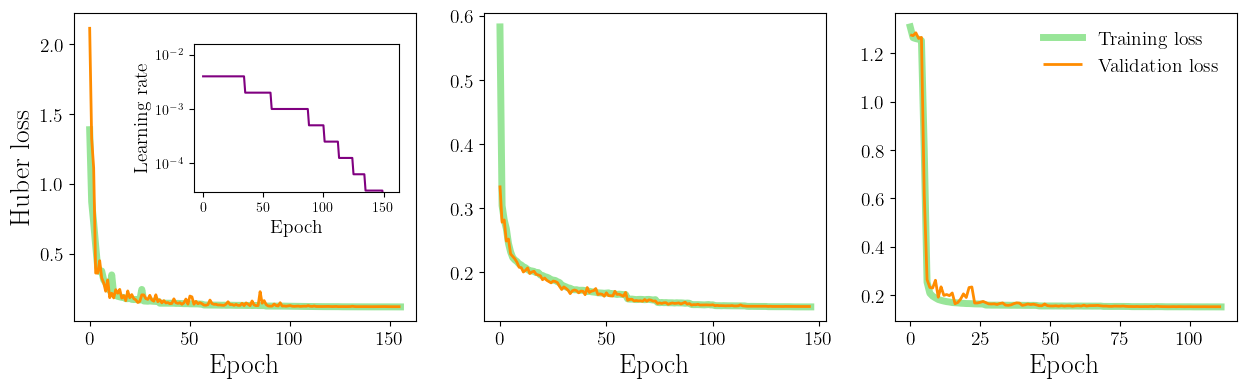

In [20]:
# free up memory from previous plots_________________
plt.close('all')
plt.clf()

import matplotlib.font_manager
from matplotlib import rc

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

import os

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")

h_drag = history_drag.history
epoch = range(len(h_drag['loss']))
print(h_drag.keys())
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.plot(epoch,h_drag['loss'],label=r"Training loss",lw=5,alpha=0.5,color='limegreen')
ax1.plot(epoch,h_drag['val_loss'],label=r"Validation loss",lw=2,dashes=(5,0),color='darkorange')
ax1.set_xlabel(r"Epoch",fontsize=20)
ax1.set_ylabel(r"Huber loss",fontsize=20)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax1, width="120%", height="120%",bbox_to_anchor=(.35, .5, .5, .4),
                   bbox_transform=ax1.transAxes, loc=2, borderpad=0)
axins.plot(epoch,h_drag['lr'],color='purple')
axins.set_xlabel(r"Epoch",fontsize=14)
axins.set_ylabel(r"Learning rate",fontsize=14)
axins.set_yscale('log')
axins.set_yticks([1e-4,1e-3,1e-2],fontsize=12)
axins.set_ylim([3e-5,1.6e-2])
# axins.set_xticks([0,60,120],fontsize=12)
axins.minorticks_off()
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

np.save('Huber_loss_drag_epoch.npy',epoch)
np.save('Huber_loss_drag_train_loss.npy',h_drag['loss'])
np.save('Huber_loss_drag_val_loss.npy',h_drag['val_loss'])
np.save('Huber_loss_drag_lr.npy',h_drag['lr'])

h_lift = history_lift.history
epoch = range(len(h_lift['loss']))
ax2.plot(epoch,h_lift['loss'],label=r"Training loss",lw=5,alpha=0.5,color='limegreen')
ax2.plot(epoch,h_lift['val_loss'],label=r"Validation loss",lw=2,dashes=(5,0),color='darkorange')
ax2.set_xlabel(r"Epoch",fontsize=20)
# ax2.set_ylabel(r"Huber loss",fontsize=20)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=14)

np.save('Huber_loss_lift_epoch.npy',epoch)
np.save('Huber_loss_lift_train_loss.npy',h_lift['loss'])
np.save('Huber_loss_lift_val_loss.npy',h_lift['val_loss'])

h_torque = history_torque.history
epoch = range(len(h_torque['loss']))
ax3.plot(epoch,h_torque['loss'],label=r"Training loss",lw=5,alpha=0.5,color='limegreen')
ax3.plot(epoch,h_torque['val_loss'],label=r"Validation loss",lw=2,dashes=(5,0),color='darkorange')
ax3.set_xlabel(r"Epoch",fontsize=20)
# ax2.set_ylabel(r"Huber loss",fontsize=20)
ax3.xaxis.set_tick_params(labelsize=14)
ax3.yaxis.set_tick_params(labelsize=14)

np.save('Huber_loss_torque_epoch.npy',epoch)
np.save('Huber_loss_torque_train_loss.npy',h_torque['loss'])
np.save('Huber_loss_torque_val_loss.npy',h_torque['val_loss'])

# ax1.legend(loc=0,edgecolor='none',prop={'size':14}, framealpha=1)
# ax2.legend(loc=0,edgecolor='none',prop={'size':14}, framealpha=1)
ax3.legend(loc=0,edgecolor='none',prop={'size':14}, framealpha=1)

os.chdir("../../")
# fig.savefig("Plots/Huber_loss.pdf", bbox_inches="tight")

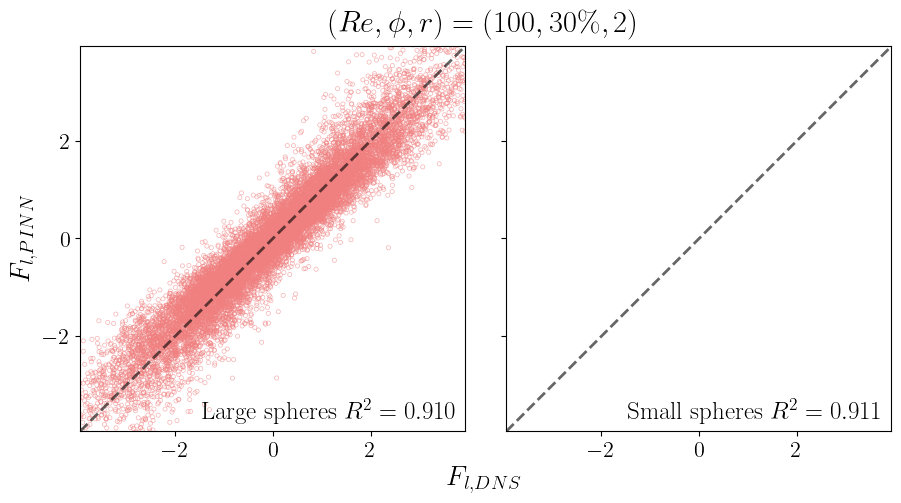

In [191]:
Re = 1
phi = 15

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
Y_large_test_plot = np.load(f'Re{Re}_phi{phi}_large_true_torque.npy')
Y_large_pred_test_plot = np.load(f'Re{Re}_phi{phi}_large_pred_torque.npy')
Y_small_test_plot = np.load(f'Re{Re}_phi{phi}_small_true_torque.npy')
Y_small_pred_test_plot = np.load(f'Re{Re}_phi{phi}_small_pred_torque.npy')
os.chdir("../../")

import datashader as ds
import matplotlib.font_manager
import seaborn as sns
from datashader.mpl_ext import dsshow
from matplotlib import rc
from scipy import stats

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

Y_large_test_plot_temp = np.array(Y_small_test_plot)
Y_large_pred_test_plot_temp = np.array(Y_small_pred_test_plot)

Y_large_test_plot_temp = np.sum(Y_large_test_plot_temp,axis=1).reshape(-1,1)
Y_large_pred_test_plot_temp = np.sum(Y_large_pred_test_plot_temp,axis=1).reshape(-1,1)

Y_large_test_plot_temp = np.array(Y_large_test_plot_temp, dtype=float)
Y_large_pred_test_plot_temp = np.array(Y_large_pred_test_plot_temp, dtype=float)

dataset = pd.DataFrame({'F_lDNS': Y_large_test_plot_temp.flatten(), 'F_lPINN': Y_large_pred_test_plot_temp.flatten()})

lim1 = np.mean(Y_small_test_plot) - 3.5*np.std(Y_small_test_plot)
lim2 = np.mean(Y_small_test_plot) + 3.5*np.std(Y_small_test_plot)

fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11,5))
fig.subplots_adjust(wspace=0)

ax1.scatter(Y_large_test_plot_temp, Y_large_pred_test_plot_temp,
                marker='o',
                s=9, linewidth=0.5,
                alpha=0.6,
                edgecolor='lightcoral', facecolor='none')
ax1.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='black', linewidth=2, alpha=0.6)
    
ax1.set_aspect('equal')
ax1.set_xlim((1.0*lim1, 1.0*lim2))
ax1.set_ylim((1.0*lim1, 1.0*lim2))

x_ann = ax1.get_xlim()[1] - 0.02*(plt.xlim()[1]-plt.xlim()[0])
y_ann = ax1.get_ylim()[0] + 0.02*(plt.ylim()[1]-plt.ylim()[0])
ax1.annotate(str(r'Large spheres $R^2 = ' + f'{Average_large_test_scores:.3f} $'), 
                 xy=(x_ann, y_ann),
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 fontsize=18);

ax1.set_xlabel(r'$F_{l,DNS}$',fontsize=20,x=1.05)
ax1.set_ylabel(r'$F_{l,PINN}$',fontsize=20)

ax1.set_title(r'$(Re,\phi,r)=(100,30\%,2)$',fontsize=22,x=1.05,pad=10)

from matplotlib.ticker import AutoMinorLocator, MaxNLocator, MultipleLocator

ax1.xaxis.set_major_locator(MaxNLocator(5))
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#=================================================================

# ax2.scatter(Y_small_test_plot, Y_small_pred_test_plot,
#                 marker='o',
#                 s=9, linewidth=0.5,
#                 alpha=0.6,
#                 edgecolor='cornflowerblue', facecolor='none')
ax2.plot([lim1, lim2], [lim1, lim2], linestyle='--', color='black', linewidth=2, alpha=0.6)
    
ax2.set_aspect('equal')

x_ann = ax2.get_xlim()[1] - 0.02*(plt.xlim()[1]-plt.xlim()[0])
y_ann = ax2.get_ylim()[0] + 0.02*(plt.ylim()[1]-plt.ylim()[0])
ax2.annotate(str(r'Small spheres $R^2 = ' + f'{Average_small_test_scores:.3f} $'), 
                 xy=(x_ann, y_ann),
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 fontsize=18);

from matplotlib.ticker import AutoMinorLocator, MaxNLocator, MultipleLocator

ax2.xaxis.set_tick_params(labelsize=16)

# fig.savefig("Plots/Fl_Re100_phi30_r2.pdf", bbox_inches="tight")

## Re-visit probability map

In [168]:
cmaps = {}
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

## $F_x$

2000/2000 [==============================] - 4s 2ms/step
(64000,)
(2, 15917)
2000/2000 [==============================] - 4s 2ms/step
(64000,)
(2, 21705)
2000/2000 [==============================] - 3s 2ms/step
(64000,)
(2, 16998)
2000/2000 [==============================] - 3s 2ms/step
(64000,)
(2, 23105)


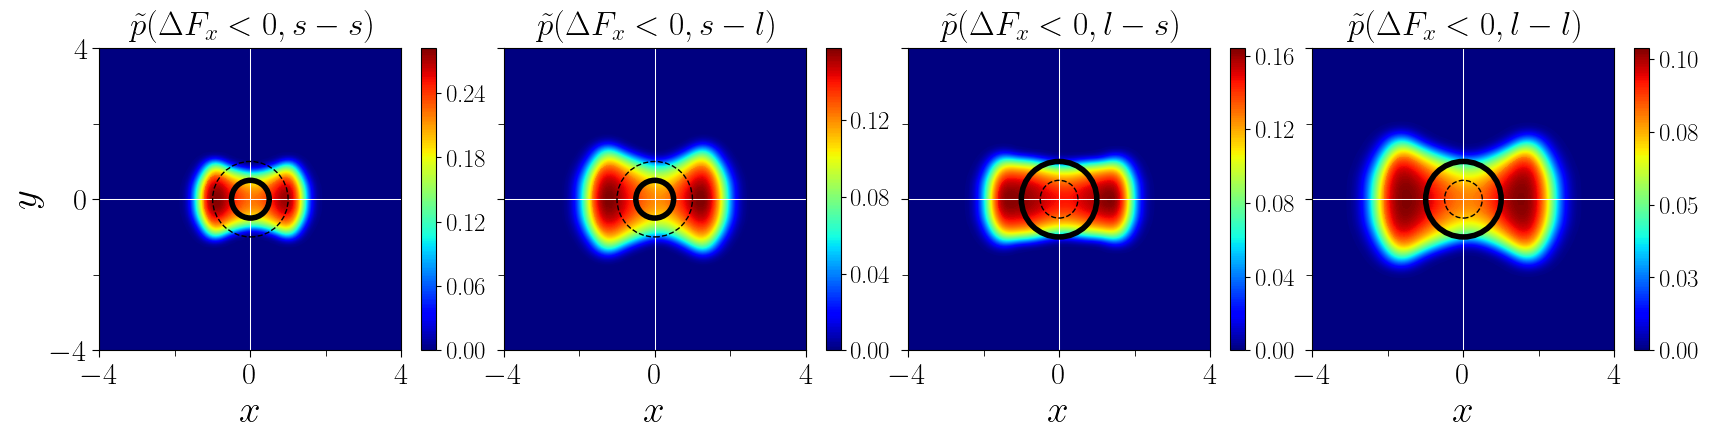

In [19]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'F_x'
Re = 1
phi = 30

bandwidth = 1.2
levels=200
grid_n = 40
grid_plot = 100
lim_plot = 4
fig = plt.figure(figsize=(20,5))

#=================================== s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
z_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[p_pred[:,-1]<0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax1 = plt.subplot(141)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour1 = ax1.contourf(xx, yy, f,
                       cmap='jet',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=2)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax1.add_patch(circ2)

#=================================== s-l interaction ===================================

r_ref = 0.5
if phi == 15 or phi == 30:
    r_ngb = 1
elif phi == 20:
    r_ngb = 0.75
elif phi == 40:
    r_ngb = 1.25

if r_ref == 1:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[p_pred[:,-1]<0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax2 = plt.subplot(142)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour2 = ax2.contourf(xx, yy, f,
                        cmap='jet',
                        levels=levels,
                        zorder=0,
                        alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=2)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax2.add_patch(circ2)

#=================================== l-s interaction ===================================

r_ngb = 0.5
if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
    
r_cnt = 0.5 
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[p_pred[:,-1]<0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax3 = plt.subplot(143)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour3 = ax3.contourf(xx, yy, f,
                        cmap='jet',
                        levels=levels,
                        zorder=0,
                        alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=2)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax3.add_patch(circ2)

#=================================== l-l interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = r_ref

r_cnt = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[p_pred[:,-1]<0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax4 = plt.subplot(144)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour4 = ax4.contourf(xx, yy, f,
                        cmap='jet',
                        levels=levels,
                        zorder=0,
                        alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=2)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax4.add_patch(circ2)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_yticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xticks(np.linspace(-4,4,3))
    ax[i].set_yticks(np.linspace(-4,4,3))
    ax[i].set_xlabel('$ x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ y $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='white', linewidth=0.75, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='white', linewidth=0.75, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$\tilde{p}(\Delta F_x<0,s-s)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_x<0,s-l)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_x<0,l-s)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_x<0,l-l)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

    # # Color bar________________________________
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cb = plt.colorbar(contour[i], cax=cax, format='%.2f')

    from matplotlib.ticker import FormatStrFormatter
    cb.ax.tick_params(labelsize=18)

    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family('Times New Roman')

    # Set the font name for axis tick labels______________
    for tick in ax[i].get_xticklabels():
        tick.set_fontname('Times New Roman')
    for tick in ax[i].get_yticklabels():
        tick.set_fontname('Times New Roman')
    # remove white lines separating the contours_______________
    for c in contour[i].collections:
        c.set_edgecolor('face')

    # Adjust number of ticks in colorbar
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
    cb.locator = tick_locator
    cb.update_ticks()

fig.savefig(f"Plots/{coord}-_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)

## $F_y$

2000/2000 [==============================] - 5s 2ms/step
(64000,)
(2, 9714)
2000/2000 [==============================] - 4s 2ms/step
(64000,)
(2, 14183)
2000/2000 [==============================] - 4s 2ms/step
(64000,)
(2, 11424)
2000/2000 [==============================] - 4s 2ms/step
(64000,)
(2, 16600)


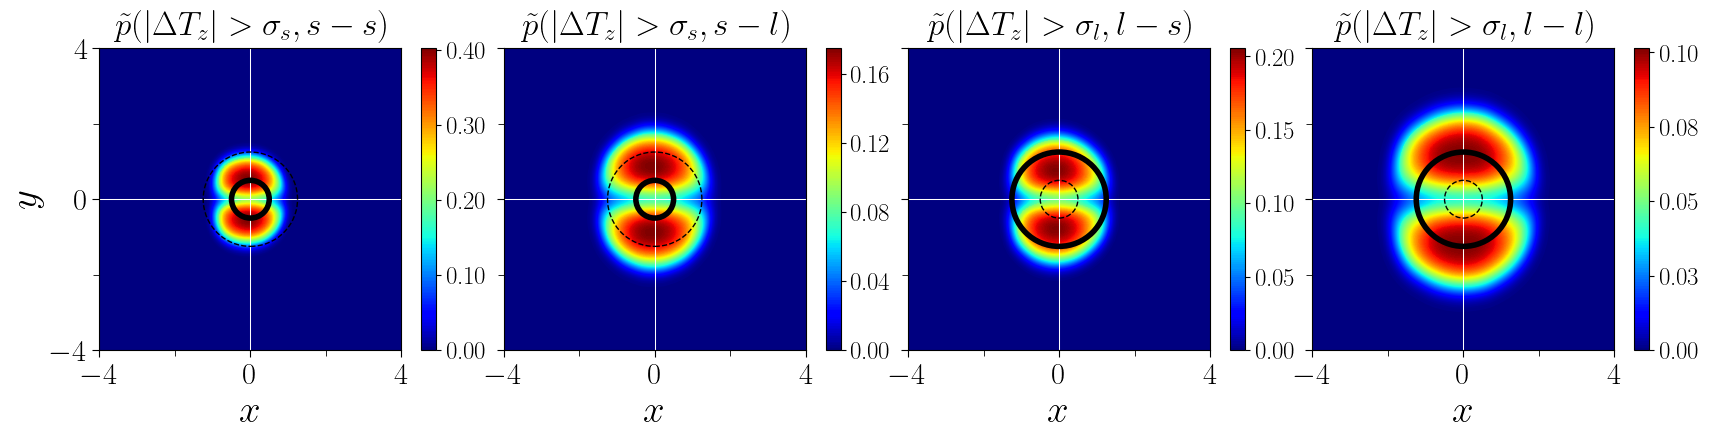

In [65]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'T_L'
Re = 10
phi = 40

bandwidth = 1.2
levels=200
grid_n = 40
grid_plot = 100
lim_plot = 4
fig = plt.figure(figsize=(20,5))
LINECOLOR = 'black'

#=================================== s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
z_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
std = p_pred.std()
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[abs(p_pred[:,-1])>std]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax1 = plt.subplot(141)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour1 = ax1.contourf(xx, yy, f,
                       cmap='jet',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=4,
                    zorder=2)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax1.add_patch(circ2)

#=================================== s-l interaction ===================================

r_ref = 0.5
if phi == 15 or phi == 30:
    r_ngb = 1
elif phi == 20:
    r_ngb = 0.75
elif phi == 40:
    r_ngb = 1.25

if r_ref == 1:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
std = p_pred.std()
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[abs(p_pred[:,-1])>std]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax2 = plt.subplot(142)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour2 = ax2.contourf(xx, yy, f,
                        cmap='jet',
                        levels=levels,
                        zorder=0,
                        alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=4,
                    zorder=2)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax2.add_patch(circ2)

#=================================== l-s interaction ===================================

r_ngb = 0.5
if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
    
r_cnt = 0.5 
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
std = p_pred.std()
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[abs(p_pred[:,-1])>std]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax3 = plt.subplot(143)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour3 = ax3.contourf(xx, yy, f,
                        cmap='jet',
                        levels=levels,
                        zorder=0,
                        alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=4,
                    zorder=2)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax3.add_patch(circ2)

#=================================== l-l interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = r_ref

r_cnt = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim, lim, grid_n)
y_range = np.linspace(-lim, lim, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)
p_pred = intermediate_layer_model.predict([p_positions,p_add]).sum(1)
std = p_pred.std()
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim]
p_pred = p_pred[abs(p_pred[:,-1])>std]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax4 = plt.subplot(144)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour4 = ax4.contourf(xx, yy, f,
                        cmap='jet',
                        levels=levels,
                        zorder=0,
                        alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=4,
                    zorder=2)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor=LINECOLOR,
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax4.add_patch(circ2)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_yticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xticks(np.linspace(-4,4,3))
    ax[i].set_yticks(np.linspace(-4,4,3))
    ax[i].set_xlabel('$ x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ y $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='white', linewidth=0.75, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='white', linewidth=0.75, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

    # # Color bar________________________________
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cb = plt.colorbar(contour[i], cax=cax, format='%.2f')

    from matplotlib.ticker import FormatStrFormatter
    cb.ax.tick_params(labelsize=18)

    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family('Times New Roman')

    # Set the font name for axis tick labels______________
    for tick in ax[i].get_xticklabels():
        tick.set_fontname('Times New Roman')
    for tick in ax[i].get_yticklabels():
        tick.set_fontname('Times New Roman')
    # remove white lines separating the contours_______________
    for c in contour[i].collections:
        c.set_edgecolor('face')

    # Adjust number of ticks in colorbar
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
    cb.locator = tick_locator
    cb.update_ticks()

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/")
fig.savefig(f"Plots/{coord}-_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)

## Distant neighbors

### Separate contribution

6750/6750 [==============================] - 13s 2ms/step
(216000,)
(2, 46790)
6750/6750 [==============================] - 13s 2ms/step
(216000,)
(2, 45766)
6750/6750 [==============================] - 12s 2ms/step
(216000,)
(2, 39702)
6750/6750 [==============================] - 14s 2ms/step
(216000,)
(2, 35332)


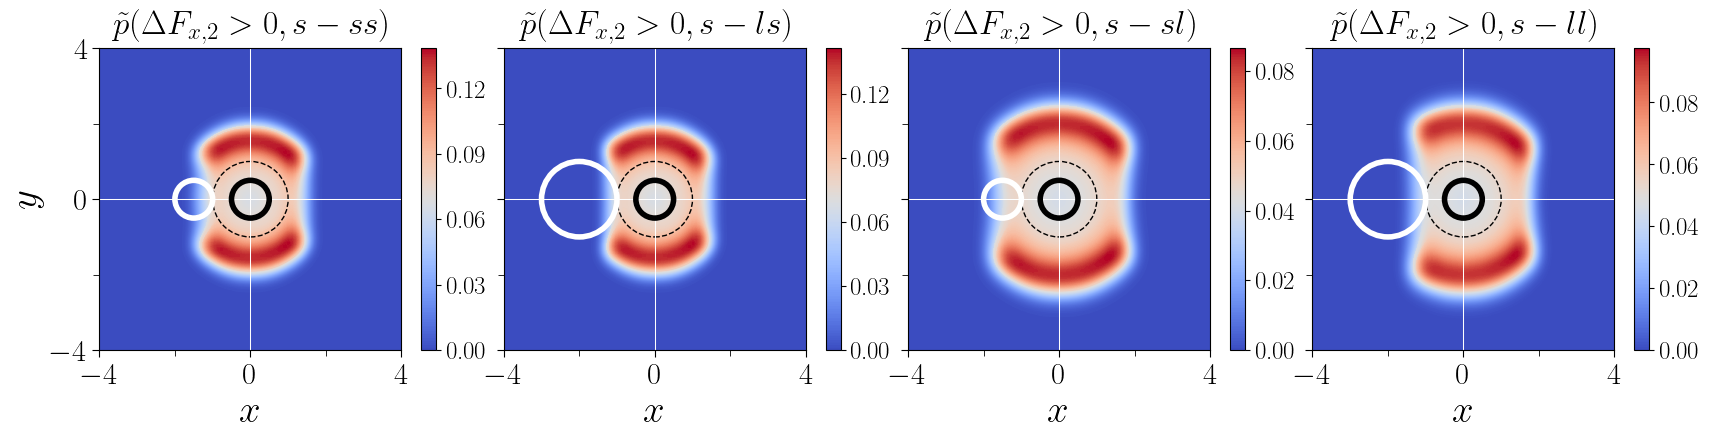

In [111]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'F_x'
Re = 100
phi = 15

bandwidth = 1.2
levels=200
grid_n = 10
grid_plot = 100
lim_plot = 4
fig = plt.figure(figsize=(20,5))

#=================================== s-s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
r_1   = 0.5
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax1 = plt.subplot(141)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour1 = ax1.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax1.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax1.add_patch(circ3)

#=================================== s-l-s interaction ===================================

r_ngb = 0.5
r_ref = 0.5
r_1   = 1
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax2 = plt.subplot(142)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour2 = ax2.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax2.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax2.add_patch(circ3)

#=================================== s-s-l interaction ===================================

r_ngb = 1
r_ref = 0.5
r_1   = 0.5
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax3 = plt.subplot(143)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour3 = ax3.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax3.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax3.add_patch(circ3)

#=================================== s-l-l interaction ===================================

r_ngb = 1
r_ref = 0.5
r_1   = 1
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax4 = plt.subplot(144)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour4 = ax4.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax4.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax4.add_patch(circ3)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_yticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xticks(np.linspace(-4,4,3))
    ax[i].set_yticks(np.linspace(-4,4,3))
    ax[i].set_xlabel('$ x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ y $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='white', linewidth=0.75, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='white', linewidth=0.75, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-ss)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-ls)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-sl)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-ll)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

    # # Color bar________________________________
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cb = plt.colorbar(contour[i], cax=cax, format='%.2f')

    from matplotlib.ticker import FormatStrFormatter
    cb.ax.tick_params(labelsize=18)

    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family('Times New Roman')

    # Set the font name for axis tick labels______________
    for tick in ax[i].get_xticklabels():
        tick.set_fontname('Times New Roman')
    for tick in ax[i].get_yticklabels():
        tick.set_fontname('Times New Roman')
    # remove white lines separating the contours_______________
    for c in contour[i].collections:
        c.set_edgecolor('face')

    # Adjust number of ticks in colorbar
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
    cb.locator = tick_locator
    cb.update_ticks()

fig.savefig(f"Plots/{coord}+_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)

### Combined contribution

In [133]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'F_x'
Re = 100
phi = 15

bandwidth = 1.2
levels=200
grid_n = 10
grid_plot = 100
lim_plot = 4
fig = plt.figure(figsize=(20,5))

#=================================== s-s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
r_1   = 0.5
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=[model_re.get_layer(f'summation0').output,model_re.get_layer(f'summation1').output])
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add])
p_pred1 = p_pred[0].sum(1)
p_pred2 = p_pred[1].sum(1)
print(p_pred1.shape)
p_pred = np.hstack((p_positions,p_pred1.reshape(-1, 1),p_pred2.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[(p_pred[:,-1]+p_pred[:,-2])>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax1 = plt.subplot(141)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour1 = ax1.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax1.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax1.add_patch(circ3)

#=================================== s-l-s interaction ===================================

r_ngb = 0.5
r_ref = 0.5
r_1   = 1
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax2 = plt.subplot(142)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour2 = ax2.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax2.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax2.add_patch(circ3)

#=================================== s-s-l interaction ===================================

r_ngb = 1
r_ref = 0.5
r_1   = 0.5
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax3 = plt.subplot(143)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour3 = ax3.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax3.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax3.add_patch(circ3)

#=================================== s-l-l interaction ===================================

r_ngb = 1
r_ref = 0.5
r_1   = 1
if r_ref > 0.6:
    r_cnt = 0.5
else:
    if phi == 15 or phi == 30:
        r_cnt = 1
    elif phi == 20:
        r_cnt = 0.75
    elif phi == 40:
        r_cnt = 1.25
lim = -(r_1+r_ref+0.5)
lim_2nd = r_ref+r_ngb+1
x_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
y_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
z_range = np.linspace(-lim_2nd, lim_2nd, grid_n)
xx, yy, zz= np.meshgrid(x_range, y_range, z_range)
rr = np.ones(xx.shape)*r_ngb
p_positions = np.hstack((
                        xx.reshape(-1, 1),
                        yy.reshape(-1, 1),
                        zz.reshape(-1, 1)
                        ))
p_positions = np.hstack((
                        p_positions,
                        rr.reshape(-1, 1),
                        ))
p_1 = np.tile(np.array([lim,0,0,r_1]),(p_positions.shape[0],1))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(p_positions.shape[0],1))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                         model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation1').output)
p_pred = intermediate_layer_model.predict([p_1,p_positions,p_add]).sum(1)
print(p_pred.shape)
p_pred = np.hstack((p_positions,p_pred.reshape(-1, 1)))
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)>(lim_2nd-0.5)]
p_pred = p_pred[np.linalg.norm(p_pred[:,:3],axis=1)<lim_2nd]
p_pred = p_pred[np.linalg.norm((p_pred[:,:3]-np.tile(np.array([lim,0,0]),(p_pred.shape[0],1))),axis=1)>(r_1+r_ngb)]
p_pred = p_pred[p_pred[:,-1]>0]
data = np.vstack((p_pred[:,0], p_pred[:,1]))
print(data.shape)
data_tmp = np.vstack((p_pred[:,0], -p_pred[:,1]))
data = np.hstack((data,data_tmp))
kde = gaussian_kde(data)
kde.set_bandwidth(bandwidth * kde.scotts_factor())

ax4 = plt.subplot(144)

x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
mesh = np.vstack([xx.ravel(), yy.ravel()])
arr = kde(mesh)
f = np.reshape(arr.T, xx.shape)

contour4 = ax4.contourf(xx, yy, f,
                       cmap='coolwarm',
                       levels=levels,
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=4,
                    zorder=3)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_cnt,
                    alpha=1,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=1)
ax4.add_patch(circ2)

circ3 = plt.Circle((lim,0), radius=r_1,
                    alpha=1,
                    facecolor='none',
                    edgecolor='white',
                    linewidth=4,
                    zorder=2)
ax4.add_patch(circ3)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_yticks(range(-lim_plot,lim_plot+1,2))
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xticks(np.linspace(-4,4,3))
    ax[i].set_yticks(np.linspace(-4,4,3))
    ax[i].set_xlabel('$ x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ y $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='white', linewidth=0.75, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='white', linewidth=0.75, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-ss)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-ls)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-sl)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$\tilde{p}(\Delta F_{x,2}>0,s-ll)$',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

    # # Color bar________________________________
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cb = plt.colorbar(contour[i], cax=cax, format='%.2f')

    from matplotlib.ticker import FormatStrFormatter
    cb.ax.tick_params(labelsize=18)

    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family('Times New Roman')

    # Set the font name for axis tick labels______________
    for tick in ax[i].get_xticklabels():
        tick.set_fontname('Times New Roman')
    for tick in ax[i].get_yticklabels():
        tick.set_fontname('Times New Roman')
    # remove white lines separating the contours_______________
    for c in contour[i].collections:
        c.set_edgecolor('face')

    # Adjust number of ticks in colorbar
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
    cb.locator = tick_locator
    cb.update_ticks()

fig.savefig(f"Plots/{coord}+_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)

32/32 [==============================] - 0s 4ms/step
(1000,)
(2, 0)


ValueError: `dataset` input should have multiple elements.

<Figure size 2000x500 with 0 Axes>

## Contribution contour

### $F_x$

79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.5
Min = -3.1
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 4.0
Min = -6.8
79/79 [==============================] - 0s 4ms/step
(50, 50)
Max = 2.2
Min = -1.9
79/79 [==============================] - 0s 3ms/step
(50, 50)
Max = 7.0
Min = -7.0


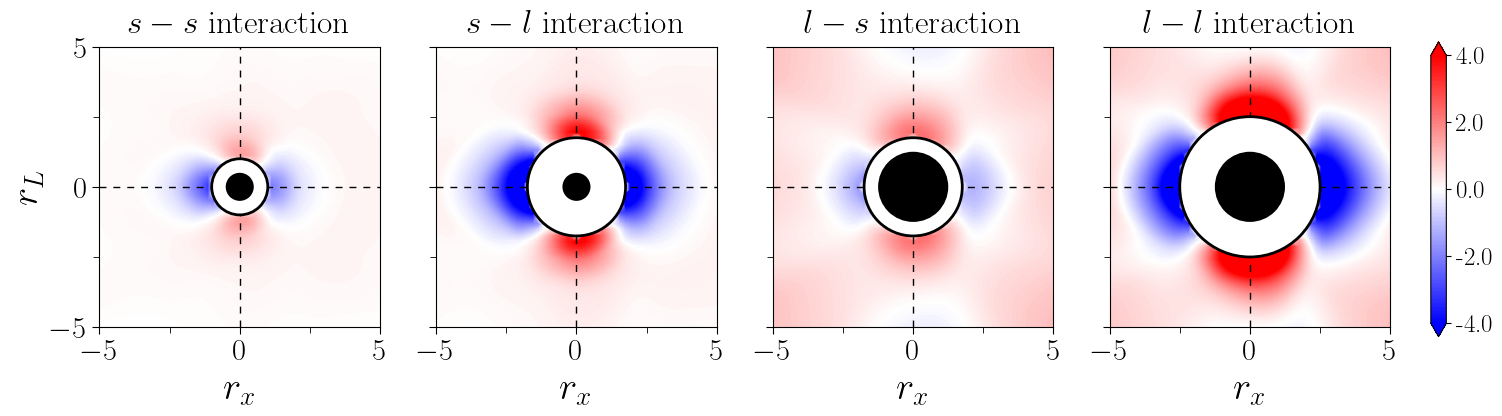

In [187]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'F_x'
Re = 10
phi = 40

cb_max = 4.
levels = np.linspace(-cb_max,cb_max,200)
CMAP = 'bwr'
grid_plot = 50
n_rot = 2**3+1
lim_plot = 5
fig = plt.figure(figsize=(21,5))

#=================================== s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_x').get_weights()[0])
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)

θ_vec = np.linspace(0, 2*np.pi, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax1 = plt.subplot(151)
f = p_pred.reshape(xx.shape)

contour1 = ax1.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax1.add_patch(circ2)

#=================================== s-l interaction ===================================

if phi == 15 or phi == 30:
    r_ngb = 1
elif phi == 20:
    r_ngb = 0.75
elif phi == 40:
    r_ngb = 1.25
r_ref = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_x').get_weights()[0])
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)

θ_vec = np.linspace(0, 2 * np.pi, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax2 = plt.subplot(152)
f = p_pred.reshape(xx.shape)

contour2 = ax2.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax2.add_patch(circ2)

#=================================== l-s interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_x').get_weights()[0])
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)

θ_vec = np.linspace(0, 2 * np.pi, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax3 = plt.subplot(153)
f = p_pred.reshape(xx.shape)

contour3 = ax3.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax3.add_patch(circ2)

#=================================== l-l interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = r_ref
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_x').get_weights()[0])
os.chdir("../../")

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'summation0').output)

θ_vec = np.linspace(0, 2 * np.pi, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax4 = plt.subplot(154)
f = p_pred.reshape(xx.shape)

contour4 = ax4.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both",
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax4.add_patch(circ2)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks([-lim_plot,0,lim_plot])
    ax[i].set_yticks([-lim_plot,0,lim_plot])
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xlabel('$ r_x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ r_L $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$s-s$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$s-l$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$l-s$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$l-l$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

#     # # Color bar________________________________
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
#     divider = make_axes_locatable(ax[i])
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

#     from matplotlib.ticker import FormatStrFormatter
#     cb.ax.tick_params(labelsize=18)

#     for l in cb.ax.yaxis.get_ticklabels():
#         l.set_family('Times New Roman')

#     # Set the font name for axis tick labels______________
#     for tick in ax[i].get_xticklabels():
#         tick.set_fontname('Times New Roman')
#     for tick in ax[i].get_yticklabels():
#         tick.set_fontname('Times New Roman')
#     # remove white lines separating the contours_______________
#     for c in contour[i].collections:
#         c.set_edgecolor('face')

#     # Adjust number of ticks in colorbar
#     from matplotlib import ticker
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
#     cb.locator = tick_locator
#     cb.update_ticks()

ax_w, ax_h = ax4.get_position().x1, ax4.get_position().y1

# # Color bar________________________________
ax5 = plt.subplot(155)
ax5.set_position([ax5.get_position().x0-ax_w/100,ax5.get_position().y0+ax_h*0.11,ax_w/100, ax_h*0.76])
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax5)
cax = ax5
cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

from matplotlib.ticker import FormatStrFormatter

cb.ax.tick_params(labelsize=18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('Times New Roman')

# Set the font name for axis tick labels______________
for tick in ax[i].get_xticklabels():
    tick.set_fontname('Times New Roman')
for tick in ax[i].get_yticklabels():
    tick.set_fontname('Times New Roman')
# remove white lines separating the contours_______________
for c in contour[i].collections:
    c.set_edgecolor('face')

# Adjust number of ticks in colorbar
# from matplotlib import ticker
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.ax.yaxis.set_major_locator(np.linspace(-cb_max,cb_max,5))
# cb.locator = tick_locator
# cb.update_ticks()
cb.set_ticks(np.linspace(-cb_max,cb_max,5))

fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=300)
# fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.pdf", bbox_inches="tight")

### $F_L$

79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 2.715
Min = -2.885
79/79 [==============================] - 1s 9ms/step
(50, 50)
Max = 4.405
Min = -4.507
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 2.795
Min = -2.820
79/79 [==============================] - 0s 3ms/step
(50, 50)
Max = 5.786
Min = -6.148


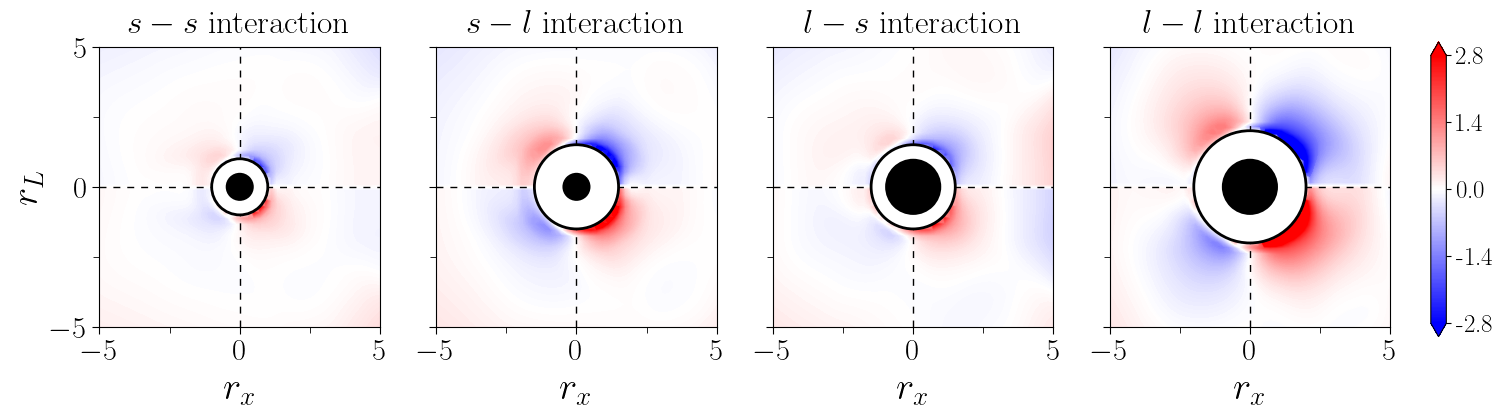

In [5]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'F_L'
Re = 100
phi = 30

cb_max = 2.8
levels = np.linspace(-cb_max,cb_max,200)
CMAP = 'bwr'
grid_plot = 50
n_rot = 2**2+1
lim_plot = 5
fig = plt.figure(figsize=(21,5))

#=================================== s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_y0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax1 = plt.subplot(151)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour1 = ax1.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax1.add_patch(circ2)

#=================================== s-l interaction ===================================

if phi == 15 or phi == 30:
    r_ngb = 1
elif phi == 20:
    r_ngb = 0.75
elif phi == 40:
    r_ngb = 1.25
r_ref = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_y0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax2 = plt.subplot(152)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour2 = ax2.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax2.add_patch(circ2)

#=================================== l-s interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_y0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax3 = plt.subplot(153)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour3 = ax3.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax3.add_patch(circ2)

#=================================== l-l interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = r_ref
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_y0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax4 = plt.subplot(154)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour4 = ax4.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both",
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax4.add_patch(circ2)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks([-lim_plot,0,lim_plot])
    ax[i].set_yticks([-lim_plot,0,lim_plot])
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xlabel('$ r_x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ r_L $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$s-s$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$s-l$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$l-s$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$l-l$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

#     # # Color bar________________________________
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
#     divider = make_axes_locatable(ax[i])
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

#     from matplotlib.ticker import FormatStrFormatter
#     cb.ax.tick_params(labelsize=18)

#     for l in cb.ax.yaxis.get_ticklabels():
#         l.set_family('Times New Roman')

#     # Set the font name for axis tick labels______________
#     for tick in ax[i].get_xticklabels():
#         tick.set_fontname('Times New Roman')
#     for tick in ax[i].get_yticklabels():
#         tick.set_fontname('Times New Roman')
#     # remove white lines separating the contours_______________
#     for c in contour[i].collections:
#         c.set_edgecolor('face')

#     # Adjust number of ticks in colorbar
#     from matplotlib import ticker
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
#     cb.locator = tick_locator
#     cb.update_ticks()

ax_w, ax_h = ax4.get_position().x1, ax4.get_position().y1

# # Color bar________________________________
ax5 = plt.subplot(155)
ax5.set_position([ax5.get_position().x0-ax_w/100,ax5.get_position().y0+ax_h*0.11,ax_w/100, ax_h*0.76])
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax5)
cax = ax5
cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

from matplotlib.ticker import FormatStrFormatter

cb.ax.tick_params(labelsize=18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('Times New Roman')

# Set the font name for axis tick labels______________
for tick in ax[i].get_xticklabels():
    tick.set_fontname('Times New Roman')
for tick in ax[i].get_yticklabels():
    tick.set_fontname('Times New Roman')
# remove white lines separating the contours_______________
for c in contour[i].collections:
    c.set_edgecolor('face')

# Adjust number of ticks in colorbar
# from matplotlib import ticker
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.ax.yaxis.set_major_locator(np.linspace(-cb_max,cb_max,5))
# cb.locator = tick_locator
# cb.update_ticks()
cb.set_ticks(np.linspace(-cb_max,cb_max,5))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse")
fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)
fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.pdf", bbox_inches="tight")

### $T_{\perp}$

79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.750
Min = -1.797
79/79 [==============================] - 0s 4ms/step
(50, 50)
Max = 3.022
Min = -3.093
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.831
Min = -1.816
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 3.324
Min = -3.429


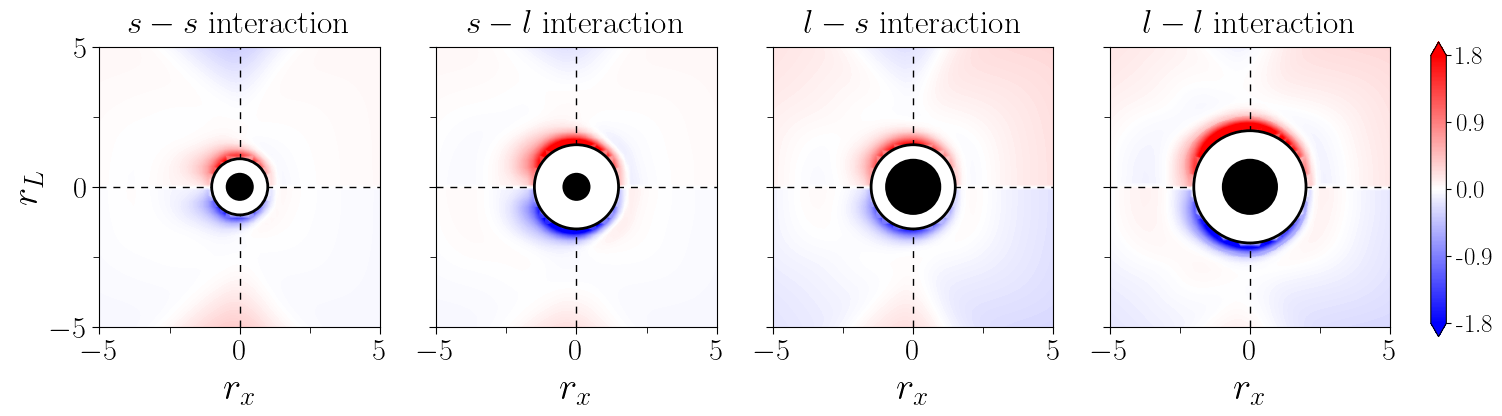

In [260]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'T_L'
Re = 10
phi = 30

cb_max = 1.8
levels = np.linspace(-cb_max,cb_max,200)
CMAP = 'bwr'
grid_plot = 50
n_rot = 2**2+1
lim_plot = 5
fig = plt.figure(figsize=(21,5))

#=================================== s-s interaction ===================================
r_ngb = 0.5
r_ref = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax1 = plt.subplot(151)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour1 = ax1.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax1.add_patch(circ2)

#=================================== s-l interaction ===================================

if phi == 15 or phi == 30:
    r_ngb = 1
elif phi == 20:
    r_ngb = 0.75
elif phi == 40:
    r_ngb = 1.25
r_ref = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax2 = plt.subplot(152)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour2 = ax2.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax2.add_patch(circ2)

#=================================== l-s interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = 0.5
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax3 = plt.subplot(153)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour3 = ax3.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax3.add_patch(circ2)

#=================================== l-l interaction ===================================

if phi == 15 or phi == 30:
    r_ref = 1
elif phi == 20:
    r_ref = 0.75
elif phi == 40:
    r_ref = 1.25
r_ngb = r_ref
lim = r_ngb+r_ref+0.5
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])

intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)

θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(1,len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_tmp = intermediate_layer_model.predict([p_positions,p_add])*weights[0]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.3f}')
print(f'Min = {p_pred.min():.3f}')

ax4 = plt.subplot(154)
f = p_pred.reshape(xx.shape)
f = (f-f[::-1])/2

contour4 = ax4.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both",
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='none',
                    linewidth=4,
                    zorder=3)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=2)
ax4.add_patch(circ2)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4]
contour = [contour1,contour2,contour3,contour4]
for i in range(len(ax)):
    ax[i].set_xticks([-lim_plot,0,lim_plot])
    ax[i].set_yticks([-lim_plot,0,lim_plot])
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xlabel('$ r_x $',fontsize=28)
    if i==0:
        ax[i].set_ylabel('$ r_L $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$s-s$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$s-l$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$l-s$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$l-l$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

#     # # Color bar________________________________
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
#     divider = make_axes_locatable(ax[i])
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

#     from matplotlib.ticker import FormatStrFormatter
#     cb.ax.tick_params(labelsize=18)

#     for l in cb.ax.yaxis.get_ticklabels():
#         l.set_family('Times New Roman')

#     # Set the font name for axis tick labels______________
#     for tick in ax[i].get_xticklabels():
#         tick.set_fontname('Times New Roman')
#     for tick in ax[i].get_yticklabels():
#         tick.set_fontname('Times New Roman')
#     # remove white lines separating the contours_______________
#     for c in contour[i].collections:
#         c.set_edgecolor('face')

#     # Adjust number of ticks in colorbar
#     from matplotlib import ticker
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
#     cb.locator = tick_locator
#     cb.update_ticks()

ax_w, ax_h = ax4.get_position().x1, ax4.get_position().y1

# # Color bar________________________________
ax5 = plt.subplot(155)
ax5.set_position([ax5.get_position().x0-ax_w/100,ax5.get_position().y0+ax_h*0.11,ax_w/100, ax_h*0.76])
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax5)
cax = ax5
cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

from matplotlib.ticker import FormatStrFormatter

cb.ax.tick_params(labelsize=18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('Times New Roman')

# Set the font name for axis tick labels______________
for tick in ax[i].get_xticklabels():
    tick.set_fontname('Times New Roman')
for tick in ax[i].get_yticklabels():
    tick.set_fontname('Times New Roman')
# remove white lines separating the contours_______________
for c in contour[i].collections:
    c.set_edgecolor('face')

# Adjust number of ticks in colorbar
# from matplotlib import ticker
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.ax.yaxis.set_major_locator(np.linspace(-cb_max,cb_max,5))
# cb.locator = tick_locator
# cb.update_ticks()
cb.set_ticks(np.linspace(-cb_max,cb_max,5))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse")
fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)
fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.pdf", bbox_inches="tight")

## Trinary Interaction

79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 0.7
Min = -0.7
1/1 [==============================] - 0s 40ms/step
[[-0.93720526]]
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.5
Min = -1.4
1/1 [==============================] - 0s 44ms/step
[[-0.93720526]]
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 0.7
Min = -0.7
1/1 [==============================] - 0s 23ms/step
[[-1.5903976]]
79/79 [==============================] - 0s 3ms/step
(50, 50)
Max = 1.5
Min = -1.4
1/1 [==============================] - 0s 25ms/step
[[-1.5903976]]
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.0
Min = -1.0
1/1 [==============================] - 0s 40ms/step
[[-0.9124948]]
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.9
Min = -1.8
1/1 [==============================] - 0s 48ms/step
[[-0.9124948]]
79/79 [==============================] - 0s 2ms/step
(50, 50)
Max = 1.0
Min = -1.0
1/1 [==========

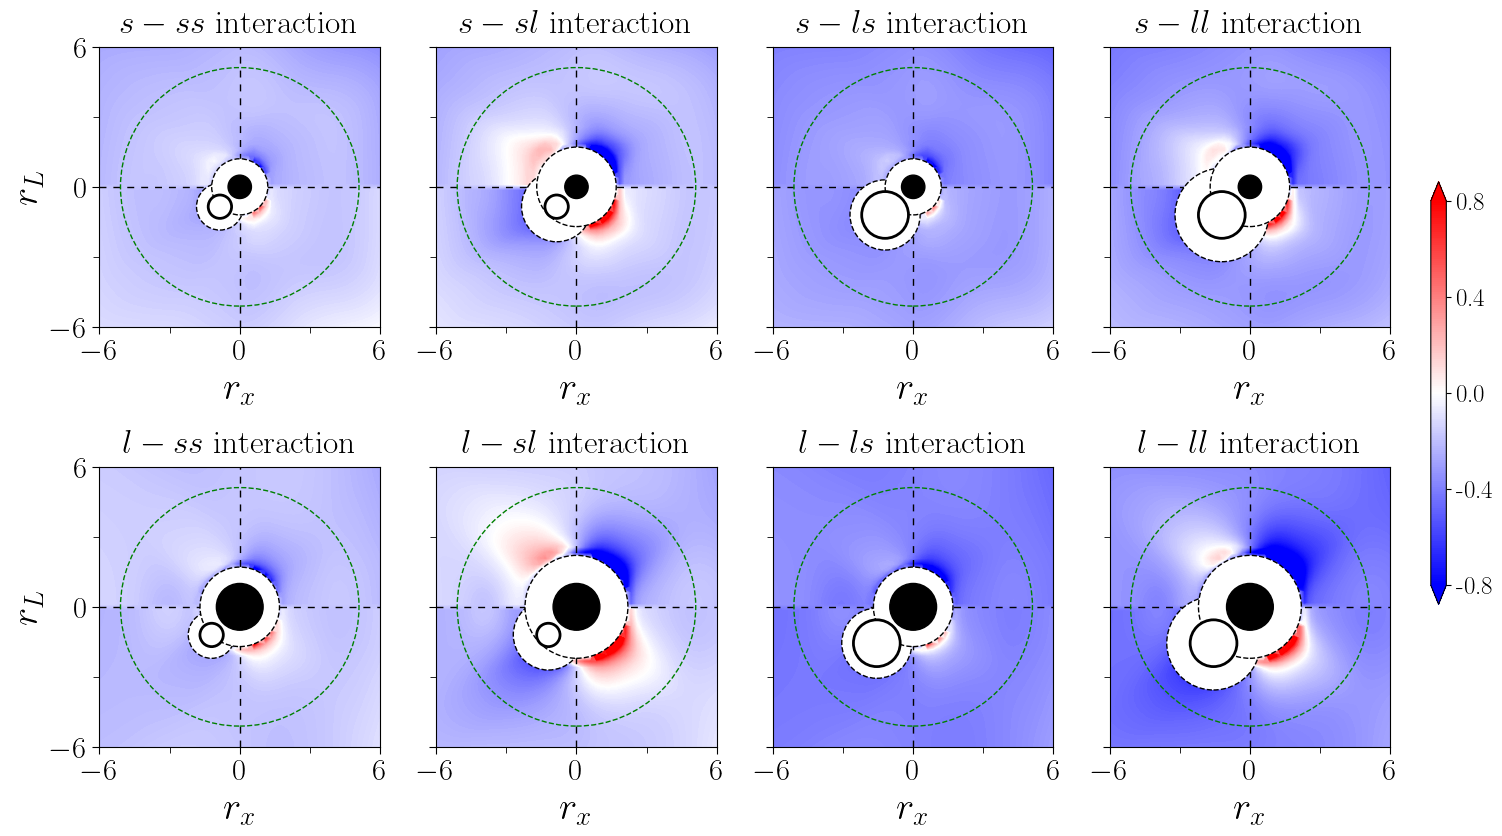

In [82]:
import keras
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

coord = r'F_L'
Re = 100
phi = 15

cb_max = 0.8
levels = np.linspace(-cb_max,cb_max,200)
# levels = np.linspace(-1.4,1.4,200)
CMAP = 'bwr'
grid_plot = 50
if coord == 'F_x':
    n_rot = 2**3+1
else:
    n_rot = 2**2+1
lim_plot = 6
fig = plt.figure(figsize=(21,10))
if coord == 'F_x':
    θ_vec = np.linspace(0, 2*np.pi, n_rot)
else:
    θ_vec = np.linspace(-np.pi/2, np.pi/2, n_rot)
# θ_vec = θ_vec[1:]
r_outer = 5.1
gap = 0.2
scale_f = 5.

#=================================== s-ss interaction ===================================
r_1   = 0.5
r_ngb = 0.5
r_ref = 0.5
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/models")
model_re = load_model(f'model_{coord}_Re{Re}_phi{phi}.h5')
if coord == 'F_x':
    weights = np.array(model_re.get_layer(f'out_x').get_weights()[0])
elif coord == 'F_L':
    weights = np.array(model_re.get_layer(f'out_y').get_weights()[0])
else:
    weights = np.array(model_re.get_layer(f'out_z').get_weights()[0])
os.chdir("../../")

if coord == 'F_x':
    intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                             model_re.get_layer(f'V_in').output],
                                             outputs=model_re.get_layer(f'summation1').output)
elif coord == 'F_L':
    intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                             model_re.get_layer(f'V_in').output],
                                             outputs=model_re.get_layer(f'proj_y1').output)
else:
    intermediate_layer_model = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'p_r1').output,
                                             model_re.get_layer(f'V_in').output],
                                             outputs=model_re.get_layer(f'proj_z1').output)
    intermediate_layer_model_first = Model(inputs=[model_re.get_layer(f'p_r0').output,model_re.get_layer(f'V_in').output],
                                outputs=model_re.get_layer(f'proj_z0').output)

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-p_1[:,:3]),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax1 = plt.subplot(251)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2
    
first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f

contour1 = ax1.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax1.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax1.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax1.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax1.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax1.add_patch(circ5)

#=================================== s-sl interaction ===================================

r_1   = 0.5
r_ngb = 1.
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-p_1[:,:3]),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax2 = plt.subplot(252)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2
    
first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f

contour2 = ax2.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax2.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax2.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax2.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax2.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax2.add_patch(circ5)

#=================================== s-ls interaction ===================================

r_1   = 1
r_ngb = 0.5
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-p_1[:,:3]),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax3 = plt.subplot(253)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2

first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f  

contour3 = ax3.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax3.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax3.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax3.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax3.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax3.add_patch(circ5)

#=================================== s-ll interaction ===================================

r_1   = 1
r_ngb = 1
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-p_1[:,:3]),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax4 = plt.subplot(254)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2

first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f
    
contour4 = ax4.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax4.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax4.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax4.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax4.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax4.add_patch(circ5)

#=================================== l-ss interaction ===================================
r_1   = 0.5
r_ngb = 0.5
r_ref = 1
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-np.tile(np.array([lim,0,0]),(p_positions.shape[0],1))),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax6 = plt.subplot(256)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2
    
first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f

contour6 = ax6.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax6.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax6.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax6.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax6.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax6.add_patch(circ5)

#=================================== l-sl interaction ===================================

r_1   = 0.5
r_ngb = 1.
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-np.tile(np.array([lim,0,0]),(p_positions.shape[0],1))),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax7 = plt.subplot(257)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2
    
first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f

contour7 = ax7.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax7.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax7.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax7.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax7.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax7.add_patch(circ5)

#=================================== l-ls interaction ===================================

r_1   = 1
r_ngb = 0.5
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-np.tile(np.array([lim,0,0]),(p_positions.shape[0],1))),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax8 = plt.subplot(258)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2
    
first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f

contour8 = ax8.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax8.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax8.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax8.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax8.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax8.add_patch(circ5)

#=================================== l-ll interaction ===================================

r_1   = 1
r_ngb = 1
lim = -(r_1+r_ref+gap)/np.sqrt(2.)
x_range = np.linspace(-lim_plot, lim_plot, grid_plot)
y_range = np.linspace(-lim_plot, lim_plot, grid_plot)
xx, yy= np.meshgrid(x_range, y_range)
rr = np.ones(xx.shape)*r_ngb

p_pred = np.zeros((len(θ_vec), xx.shape[0], xx.shape[1]))
p_add = np.tile(np.array([r_ref,phi/100,Re,0,0]),(xx.shape[0]*xx.shape[1],1))

for i in range(len(θ_vec)-1):
    θ = θ_vec[i]
    p_positions = np.hstack((
                            xx.reshape(-1, 1),
                            (yy * np.cos(θ)).reshape(-1, 1),
                            (yy * np.sin(θ)).reshape(-1, 1)
                            ))
    p_positions = np.hstack((
                            p_positions,
                            rr.reshape(-1, 1),
                            ))
    # print(np.linalg.norm(p_positions[:,:3],axis=1))
    p_1 = np.tile(np.array([lim,lim,0,r_1]),(p_positions.shape[0],1))
    p_tmp = intermediate_layer_model.predict([p_1,p_positions,p_add])*weights[1]
    p_tmp[np.linalg.norm(p_positions[:,:3],axis=1)<=(r_ref+r_ngb+gap)] = 0
    # p_tmp[np.linalg.norm((p_positions[:,:3]-np.tile(np.array([lim,0,0]),(p_positions.shape[0],1))),axis=1)<(r_1+r_ngb)] = 0
    p_pred[i, :, :] = p_tmp.reshape(xx.shape)

p_pred = p_pred.mean(axis=0)

print(p_pred.shape)
print(f'Max = {p_pred.max():.1f}')
print(f'Min = {p_pred.min():.1f}')

ax9 = plt.subplot(259)
f = p_pred.reshape(xx.shape)
if coord != 'F_x':
    f = (f-f[::-1])/2
    
first_in = intermediate_layer_model_first.predict([np.array([lim,lim,0,r_1]).reshape(1,-1)
                                                   ,np.array([r_ref,phi/100,Re,0,0]).reshape(1,-1)])*weights[0]
print(first_in)

f = f+first_in/scale_f

contour9 = ax9.contourf(xx, yy, f,
                       cmap=CMAP,
                       levels=levels,
                       extend="both", 
                       zorder=0,
                       alpha=1)

circ1 = plt.Circle((0,0), radius=r_ref,
                    alpha=1,
                    facecolor='black',
                    edgecolor='black',
                    linewidth=1,
                    zorder=4)
ax9.add_patch(circ1)
    
circ2 = plt.Circle((0,0), radius=r_ref+r_ngb+gap,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=3)
ax9.add_patch(circ2)

circ3 = plt.Circle((lim,lim), radius=r_1,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=2,
                    linestyle='-',
                    zorder=3)
ax9.add_patch(circ3)

circ4 = plt.Circle((lim,lim), radius=r_1+r_ngb,
                    alpha=1,
                    facecolor='white',
                    edgecolor='black',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax9.add_patch(circ4)

circ5 = plt.Circle((0,0), radius=r_outer,
                    alpha=1,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    linestyle='--',
                    zorder=2)
ax9.add_patch(circ5)

#=======================================================================================

ax = [ax1,ax2,ax3,ax4,ax6,ax7,ax8,ax9]
contour = [contour1,contour2,contour3,contour4,contour6,contour7,contour8,contour9]
for i in range(len(ax)):
    ax[i].set_xticks([-lim_plot,0,lim_plot])
    ax[i].set_yticks([-lim_plot,0,lim_plot])
    ax[i].set_aspect('equal')
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[i].tick_params(which='major', length=5)
    ax[i].tick_params(which='minor', length=4)
    
    # Customization of x and y labels:
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].set_xlabel('$ r_x $',fontsize=28)
    if i==0 or i==4:
        ax[i].set_ylabel('$ r_L $',fontsize=28)
    else:
        ax[i].axes.yaxis.set_ticklabels([])
    ax[i].vlines(x=0, ymin=yy.min(), ymax=yy.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    ax[i].hlines(y=0, xmin=xx.min(), xmax=xx.max(), color='black', linestyle=(0, (5, 5)), linewidth=1, zorder=1)
    
    if i == 0:
        ax[i].set_title(r'$s-ss$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 1: 
        ax[i].set_title(r'$s-sl$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 2: 
        ax[i].set_title(r'$s-ls$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 3: 
        ax[i].set_title(r'$s-ll$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)
    elif i == 4:
        ax[i].set_title(r'$l-ss$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-s)$',fontsize=28,pad=10)
    elif i == 5: 
        ax[i].set_title(r'$l-sl$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_s,s-l)$',fontsize=28,pad=10)
    elif i == 6: 
        ax[i].set_title(r'$l-ls$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-s)$',fontsize=28,pad=10)
    elif i == 7: 
        ax[i].set_title(r'$l-ll$ interaction',fontsize=24,pad=10)
        # ax[i].set_title(r'$\tilde{p}(\left|\Delta T_z\right|>\sigma_l,l-l)$',fontsize=28,pad=10)

#     # # Color bar________________________________
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
#     divider = make_axes_locatable(ax[i])
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

#     from matplotlib.ticker import FormatStrFormatter
#     cb.ax.tick_params(labelsize=18)

#     for l in cb.ax.yaxis.get_ticklabels():
#         l.set_family('Times New Roman')

#     # Set the font name for axis tick labels______________
#     for tick in ax[i].get_xticklabels():
#         tick.set_fontname('Times New Roman')
#     for tick in ax[i].get_yticklabels():
#         tick.set_fontname('Times New Roman')
#     # remove white lines separating the contours_______________
#     for c in contour[i].collections:
#         c.set_edgecolor('face')

#     # Adjust number of ticks in colorbar
#     from matplotlib import ticker
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cb.ax.yaxis.set_major_locator(ticker.AutoLocator())
#     cb.locator = tick_locator
#     cb.update_ticks()

ax_w, ax_h = ax4.get_position().x1, ax4.get_position().y1

# # Color bar________________________________
ax5 = plt.subplot(155)
ax5.set_position([ax5.get_position().x0-ax_w/100,ax5.get_position().y0+ax_h*0.21,ax_w/100, ax_h*0.5])
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax5)
cax = ax5
cb = plt.colorbar(contour[i], cax=cax, format='%.1f')

from matplotlib.ticker import FormatStrFormatter

cb.ax.tick_params(labelsize=18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('Times New Roman')

# Set the font name for axis tick labels______________
for tick in ax[i].get_xticklabels():
    tick.set_fontname('Times New Roman')
for tick in ax[i].get_yticklabels():
    tick.set_fontname('Times New Roman')
# remove white lines separating the contours_______________
for c in contour[i].collections:
    c.set_edgecolor('face')

# Adjust number of ticks in colorbar
# from matplotlib import ticker
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.ax.yaxis.set_major_locator(np.linspace(-cb_max,cb_max,5))
# cb.locator = tick_locator
# cb.update_ticks()
cb.set_ticks(np.linspace(-cb_max,cb_max,5))

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse")
fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.jpg", bbox_inches="tight",dpi=200)
# fig.savefig(f"Plots/{coord}_Re{Re}_phi{phi}.pdf", bbox_inches="tight")

In [258]:
a = np.array([[1,2],
              [3,4]])
b = np.array([1,2])
np.linalg.norm(a,axis=1)
print(np.linspace(0,1,3))

[0.  0.5 1. ]


In [2]:
Re = 100
phi = 15
n_closest = 101
N_1 = 192

os.chdir("/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse")
dataset = pd.read_csv(f'Datasets/Re{Re}_phi0{phi}_M={n_closest}_{N_1}L',
                        header=None, delim_whitespace=True).values

i = 20
X = dataset[:,4*i:4*i+3]
Y = np.linalg.norm(X,axis=1)
print(Y.max())

4.146692403832239


1221


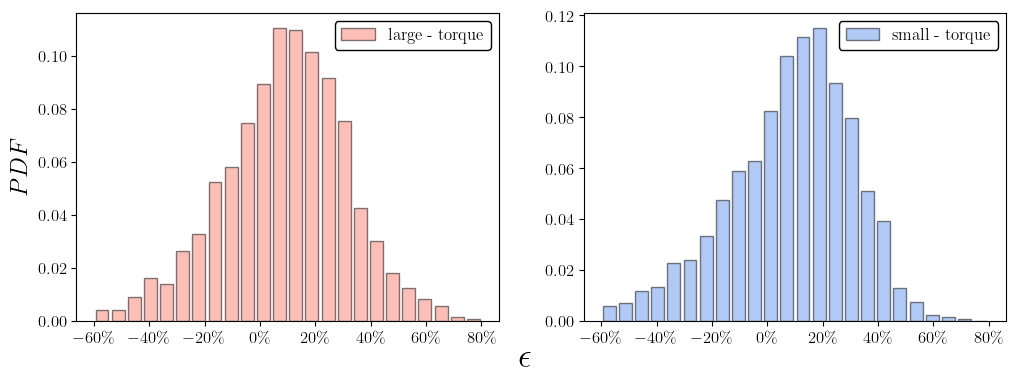

In [39]:
import matplotlib.font_manager
from matplotlib import rc

plt.rcParams["font.family"] = "Times New Roman"
rc('text', usetex=True)

Re = 1
phi = 15

def R2_val(y_true, y_pred):
    '''
    This function computes the R^2 for the callback function.
    '''
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(K.constant(y_true),axis=0))) 
    SS_res = tf.cast(SS_res, tf.float32)
    SS_tot = tf.cast(SS_tot, tf.float32)
    return 1 - SS_res / (SS_tot)

coord = r'torque'
os.chdir(f"/home/zihao/Documents/PhD/Post-Processing/3D/Bidisperse/Datasets/Paper_3/NN_data/Re{Re}_phi{phi}")
Y_large_test_plot_or = np.load(f'Re{Re}_phi{phi}_large_true_{coord}.npy')
Y_large_pred_test_plot = np.load(f'Re{Re}_phi{phi}_large_pred_{coord}.npy')
Y_small_test_plot_or = np.load(f'Re{Re}_phi{phi}_small_true_{coord}.npy')
Y_small_pred_test_plot = np.load(f'Re{Re}_phi{phi}_small_pred_{coord}.npy')
os.chdir("../../")

index = 1
factor = 1

Y_large_std = np.std(Y_large_test_plot_or[:,index])
Y_large_test_plot = Y_large_test_plot_or[abs(Y_large_test_plot_or[:,index]) > (factor*Y_large_std)]
Y_large_pred_test_plot = Y_large_pred_test_plot[abs(Y_large_test_plot_or[:,index]) > (factor*Y_large_std)]
Y_small_std = np.std(Y_small_test_plot_or[:,index])
Y_small_test_plot = Y_small_test_plot_or[abs(Y_small_test_plot_or[:,index]) > (factor*Y_small_std)]
Y_small_pred_test_plot = Y_small_pred_test_plot[abs(Y_small_test_plot_or[:,index]) > (factor*Y_small_std)]

import matplotlib.ticker as mtick

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
res=25

error_l = (Y_large_test_plot[:,index] - Y_large_pred_test_plot[:,index])/Y_large_test_plot[:,index]
error_s = (Y_small_test_plot[:,index] - Y_small_pred_test_plot[:,index])/Y_small_test_plot[:,index]

print(Y_large_test_plot[:,index].size)
# print(K.mean(K.constant(Y_large_test_plot[:,0]),axis=0))
# print(R2_val(Y_large_test_plot[:,0],Y_large_pred_test_plot[:,0]))

perp = 0.6
if coord == r'drag':
    # my_list_error_l = np.linspace(error_l.min()*perp,error_l.max()*perp,res)
    my_list_error_s = np.linspace(error_s.min()*perp,error_s.max()*perp,res)
    my_list_error_l = my_list_error_s
else:
    my_list_error_l = np.linspace(-0.6,0.8,res)
    my_list_error_s = np.linspace(-0.6,0.8,res)

ax1.hist(error_l,bins=my_list_error_l,alpha=0.5,label=f"large - {coord}",rwidth=0.8,edgecolor='black',facecolor='salmon',weights=np.ones(len(error_l)) / len(error_l))
ax2.hist(error_s,bins=my_list_error_s,alpha=0.5,label=f"small - {coord}",rwidth=0.8,edgecolor='black',facecolor='cornflowerblue',weights=np.ones(len(error_s)) / len(error_s))
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))

ax1.legend(loc=0,edgecolor='black',prop={'size':12}, framealpha=1)
ax2.legend(loc=0,edgecolor='black',prop={'size':12}, framealpha=1)

ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)

fig.supxlabel(r"$\epsilon$",fontsize=25,y=-0.02)
ax1.set_ylabel(r"$PDF$",fontsize=18)

plt.savefig(f"Relative_error_Re{Re}_phi0p{phi}_{coord}_std1.pdf", bbox_inches="tight",dpi=200)

In [117]:
# error_s = Y_small_test_plot[:,0]/Y_small_test_plot[:,0]
print(np.mean(Y_small_test_plot[:,0]))
print(Y_small_test_plot[:,0]-np.mean(Y_small_test_plot[:,0]))
mean_sum = np.sum((Y_small_test_plot[:,0]-np.mean(Y_small_test_plot[:,0]))**2)
diff_sum = np.sum((Y_small_test_plot[:,0] - Y_small_pred_test_plot[:,0])**2)
print(diff_sum/mean_sum)
print(np.sum((Y_large_test_plot[:,0] - Y_large_pred_test_plot[:,0])/Y_large_test_plot[:,0])/Y_large_test_plot[:,0].shape)

0.004410575603174521
[-0.46785497 -0.56258752 -0.08023726 ...  0.71610503  0.26720547
 -0.90829148]
0.11910342707361665
[1.66344455]
